In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import math
import random

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from ipywidgets import IntProgress
from IPython.display import display
from keras.utils.vis_utils import plot_model

**Adicionar fashion_mnist, horses_or_humans, mnist**

In [4]:
url_cat_dog = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
url_flower = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_cat = tf.keras.utils.get_file('cats_and_dogs.zip', origin=url_cat_dog, extract=True)
zip_flw = tf.keras.utils.get_file('flower_photos.tar', origin=url_flower, extract=True)

path_cat = os.path.join(os.path.dirname(zip_cat), 'cats_and_dogs_filtered')
path_flw = os.path.join(os.path.dirname(zip_flw), 'flower_photos')

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

In [6]:
train_cat = tf.keras.utils.image_dataset_from_directory(os.path.join(path_cat, 'train'), shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_cat = tf.keras.utils.image_dataset_from_directory(os.path.join(path_cat, 'validation'), shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

train_flw = tf.keras.utils.image_dataset_from_directory(path_flw, validation_split=0.2, subset="training", seed=123, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_flw = tf.keras.utils.image_dataset_from_directory(path_flw, validation_split=0.2, subset="validation", seed=123, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
cat_class_names = train_cat.class_names
flw_class_names = train_flw.class_names

# Viz

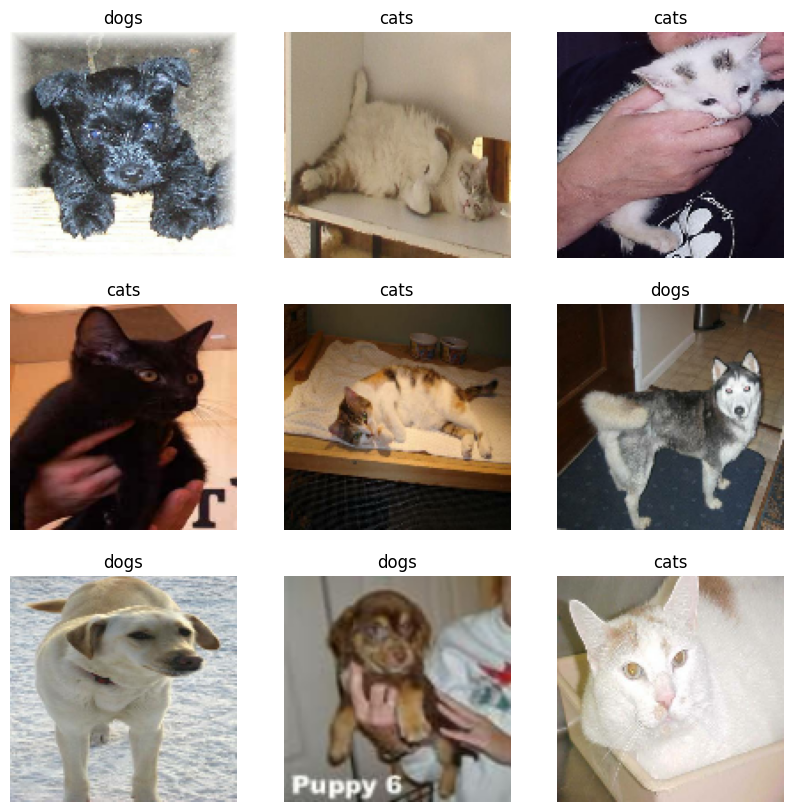

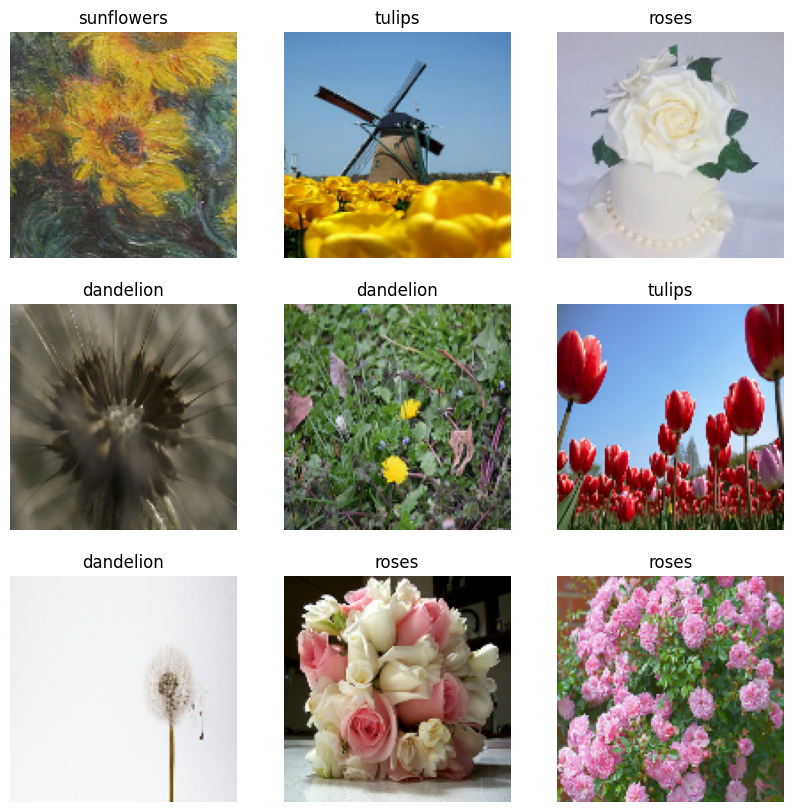

In [145]:
plt.figure(figsize=(10, 10))
for images, labels in train_cat.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(cat_class_names[labels[i]])
        plt.axis("off")

plt.show()

plt.figure(figsize=(10, 10))
for images, labels in train_flw.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(flw_class_names[labels[i]])
        plt.axis("off")

# Preprocessing

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

cat_train_ds = train_cat.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
cat_valid_ds = valid_cat.cache().prefetch(buffer_size=AUTOTUNE)

flw_train_ds = train_flw.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
flw_valid_ds = valid_flw.cache().prefetch(buffer_size=AUTOTUNE)

# Model

In [9]:
def clone_model(model):
    new_model = tf.keras.models.clone_model(model)
    new_model.set_weights(model.get_weights())
    return new_model

def generate_model(num_classes, arr_regularization=None, new_shape=None):
    dt_aug_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
    if new_shape is not None:
        dt_aug_shape = new_shape
            
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal", input_shape=dt_aug_shape),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ])
    
    if arr_regularization is None:
        arr_regularization = []
        for i in range(10):
            arr_regularization.append(None)

    if type(num_classes).__name__ != 'list':
        return Sequential([
            data_augmentation,
            layers.Rescaling(1./255),
            layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=arr_regularization[0], bias_regularizer=arr_regularization[1]),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=arr_regularization[2], bias_regularizer=arr_regularization[3]),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=arr_regularization[4], bias_regularizer=arr_regularization[5]),
            layers.MaxPooling2D(),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(128, activation='relu', kernel_regularizer=arr_regularization[6], bias_regularizer=arr_regularization[7]),
            layers.Dense(num_classes, kernel_regularizer=arr_regularization[8], bias_regularizer=arr_regularization[9])
        ])
    else:
        if new_shape is None:
            inp = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
            inp = data_augmentation(inp)
        else:
            inp = keras.Input(shape=new_shape)
            
        out = layers.Rescaling(1./255)(inp)
        out = layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=arr_regularization[0], bias_regularizer=arr_regularization[1])(out)
        out = layers.MaxPooling2D()(out)
        out = layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=arr_regularization[2], bias_regularizer=arr_regularization[3])(out)
        out = layers.MaxPooling2D()(out)
        out = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=arr_regularization[4], bias_regularizer=arr_regularization[5])(out)
        out = layers.MaxPooling2D()(out)
        out = layers.Dropout(0.2)(out)
        out = layers.Flatten()(out)
        out = layers.Dense(128, activation='relu', kernel_regularizer=arr_regularization[6], bias_regularizer=arr_regularization[7])(out)
            
        head_1 = layers.Dense(num_classes[0], name="head_1")(out)
        head_2 = layers.Dense(num_classes[1], name="head_2")(out)

        return keras.Model(inputs=inp, outputs=[head_1,head_2], name="Multiple_Head")

In [10]:
# https://stackoverflow.com/questions/62440162/how-do-i-take-l1-and-l2-regularizers-into-account-in-tensorflow-custom-training
def add_model_regularizer_loss(model):
    loss=0
    for l in model.layers:
        #if hasattr(l,'layers') and l.layers: # the layer itself is a model
        #    loss+=add_model_loss(l)
        if hasattr(l,'kernel_regularizer') and l.kernel_regularizer:
            loss+=l.kernel_regularizer(l.kernel)
        if hasattr(l,'bias_regularizer') and l.bias_regularizer:
            loss+=l.bias_regularizer(l.bias)
    return loss

@tf.custom_gradient
def scale_grad_layer(x):
    def grad(dy):
        return 5.0 * dy
    return tf.identity(x), grad

def ewc_loss(new_model):
    loss = 0
    current = new_model.trainable_weights
    for f, c, o in zip(fim, current, model1.trainable_weights):
        loss += tf.reduce_sum(f * ((c - o) ** 2))
    return loss# * (1 / 2)

def custom_evaluate(model, loss, ds_validation):
    loss_avg = tf.keras.metrics.Mean()
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        
    for x, y in ds_validation:
        logits = model(x, training=False)
        loss_value = loss(y, logits)
        
        loss_avg.update_state(loss_value)
        accuracy.update_state(y, logits)
        
    return loss_avg.result().numpy(), accuracy.result().numpy()

def custom_training(model, optimizer, loss, ds_train, num_epochs):
    #global global_grads
    train_loss_results = []
    train_accuracy_results = []
    
    #f = IntProgress(min=0, max=num_epochs)
    #display(f)
    
    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        for x, y in ds_train:
            with tf.GradientTape() as tape:
                logits = model(x, training=True)
                loss_value = loss(y, logits)
                #loss_value += add_model_regularizer_loss(model)
                loss_value += ewc_loss(model)
            
            #print(loss_value)
            grads = tape.gradient(loss_value, model.trainable_weights)
            #return grads
            #global_grads = grads
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            #raise 'hehehehe'
            
            epoch_loss_avg.update_state(loss_value)
            epoch_accuracy.update_state(y, logits)
        
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())
        print(train_loss_results[-1])
        
        #f.value += 1

    return {'loss': train_loss_results, 'accuracy': train_accuracy_results}

## Prints

In [11]:
def print_performance(title, history, epochs=None):
    val_acc = None
    val_loss = None
    
    if 'history' in history:
        acc = history.history['accuracy']
        loss = history.history['loss']
        val_acc = history.history['val_accuracy']
        val_loss = history.history['val_loss']
    else:
        acc = history['accuracy']
        loss = history['loss']
        if 'val_accuracy' in history:
            val_acc = history['val_accuracy']
            val_loss = history['val_loss']
            
    if epochs is None:
        epochs = len(loss)
    
    print(title, 'acc:', acc[-1], 'val_acc:', 'None' if val_acc is None else val_acc[-1])

    epochs_range = range(epochs)

    plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if val_acc is not None:
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if val_loss is not None:
        plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def print_filters_1d(filters):
    depth = filters.shape[-1]
    size = math.ceil(math.sqrt(depth))
    
    if depth < (size*size):
        filters = np.resize(filters, (size*size))
    
    fig, axarr = plt.subplots(1,1, figsize=(size/4, size/4))
    axarr.axis('off')
    axarr.imshow(np.reshape(filters, (size, size)))
    fig.suptitle(filters.shape, fontsize=8)

def print_filters_2d(filters):
    depth = filters.shape[-1]
    mj = filters.shape[-2]
    mi = math.ceil(depth/mj)
    fi = 0
    fig, axarr = plt.subplots(mi, mj, figsize=(20, mi))
    for i in range(mi):
        for j in range(mj):
            axarr[i][j].axis('off')
            if fi < depth:
                axarr[i][j].imshow(filters[:,:,fi,0], cmap='gray')
            fi += 1
    fig.suptitle(filters.shape, fontsize=8)
    
def print_filters_3d(filters):
    depth = filters.shape[-1]
    mj = 16
    mi = math.ceil(depth/mj)
    fi = 0
    fig, axarr = plt.subplots(mi, mj, figsize=(20, mi))
    if mi == 1:
        for j in range(mj):
            axarr[j].axis('off')
            if fi < depth:
                axarr[j].imshow(filters[:,:,fi])
            fi += 1
    else:
        for i in range(mi):
            for j in range(mj):
                axarr[i][j].axis('off')
                if fi < depth:
                    axarr[i][j].imshow(filters[:,:,fi])
                fi += 1
    fig.suptitle(filters.shape, fontsize=8)

## Activations Utils

In [12]:
def get_threshold_activation(model, dataset, neuron_layers):
    #activations = {'cnn':[], 'dnn':[]}
    activations = {}
    #maxes = {}
    #mines = {}
    means = {}
    for l in neuron_layers:
        activations[l] = None
        #maxes[l] = None
        #mines[l] = None
        means[l] = 0
    
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    ds_size = 0
    cnn_max = None
    dnn_max = None
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            ds_size += 1
            for l in range(len(model.layers)):
                out = model.layers[l](out)
                if l in neuron_layers:
                    
                    if len(out[0].shape) > 1: # cnn
                        #maxi = np.max(out[0], axis=(0,1))
                        #mini = np.min(out[0], axis=(0,1))
                        non_zero = []
                        for fil in range(out[0].shape[2]):
                            non_zero.append(np.mean(out[0][:,:,fil][out[0][:,:,fil] > 0]))
                        meani = np.mean(non_zero)
                    else:
                        #maxi = out[0].numpy()
                        #mini = out[0].numpy()
                        non_zero = out[0][out[0] > 0]
                        meani = np.mean(non_zero)
                        
                    means[l] += meani
                    continue
                        
                    if maxes[l] is None:
                        maxes[l] = maxi.copy()
                    else:
                        maxes[l] = np.max([maxes[l], maxi], axis=(0))
                        
        f.value += 1
        
    print(means)
    #mean_per_layer = {}
    for l in neuron_layers:
        #no_zero_max = maxes[l][maxes[l] > 0]
        #mean_per_layer[l] = np.mean(maxes[l])
        means[l] = means[l] / ds_size
        
    return means
        
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            ds_size += 1
            for l in range(len(model.layers)):
                out = model.layers[l](out)
                if l in neuron_layers:
                    neurons_actv = None
                    neurons_med = None
                    if len(out[0].shape) > 1: # cnn
                        #neurons_actv = np.sum(out[0], axis=(0,1))
                        #neurons_med = np.mean(out[0], axis=(0,1))
                        #neurons_std = np.std(out[0], axis=(0,1))
                        #neurons_actv = np.count_nonzero(out[0] > neurons_med, axis=(0,1))
                        neurons_actv = np.count_nonzero((out[0]/cnn_max) > 0.5, axis=(0,1))
                        #neurons_actv = np.sum(out[0].numpy()/dnn_max, axis=(0,1))
                        
                        #print(neurons_med)
                        #print(neurons_actv)
                        #for p in range(3):
                        #    print(out[0][:,:,p].shape, neurons_med[p])
                        #    print(np.count_nonzero(out[0][:,:,p] > neurons_med[p], axis=(0,1)))
                        #print_filters_3d(out[0])
                        #raise 'aaa'
                    else: # dnn
                        neurons_actv = out[0].numpy()/dnn_max
                        
                    if activations[l] is None:
                        activations[l] = neurons_actv
                    else:
                        activations[l] += neurons_actv
                    
                    #for n in range(len(neurons_actv)):
                        #key = 'cnn' if len(out[0].shape) > 1 else 'dnn'
                        #activations[key].append(neurons_actv[n])
                        #if n not in activations[l]:
                        #    activations[l][n] = []
                            #activations[l][str(n)+'_val'] = []
                        #activations[l][n].append(neurons_actv[n])
                        #if neurons_med is not None:
                        #    activations[l][str(n)+'_val'].append(neurons_med[n])
        f.value += 1
    
    print('ds_size', ds_size, 'len(dataset)', len(dataset))
    
    activations2 = {}
    for layer in activations:
        #array_activations = []
        #for neuron in activations[layer]:
        #    array_activations.append(np.mean(activations[layer][neuron]))
            
        activations2[layer] = activations[layer] / ds_size
        
    scales = {
        'cnn_max':cnn_max,
        'dnn_max':dnn_max
    }
    
    return activations2, activations, scales

def get_activation_frequency(model, dataset, neuron_layers, thresholds):
    activations = {}
    for l in neuron_layers:
        activations[l] = None
    
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    ds_size = 0
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            ds_size += 1
            for l in range(len(model.layers)):
                out = model.layers[l](out)
                if l in neuron_layers:
                    
                    if len(out[0].shape) > 1: # cnn
                        a = np.sum(out[0].numpy(), axis=(0,1))
                    else: # dnn
                        a = out[0].numpy().copy()
                        
                    a[a <= thresholds[l]] = 0.0
                    a[a > thresholds[l]] = 1.0
                    
                    if activations[l] is None:
                        activations[l] = a
                    else:
                        activations[l] += a
                    
                    #for n in range(len(a)):
                    #    if n not in activations[l]:
                    #        activations[l][n] = 0
                    #    activations[l][n] += a[n]
        f.value += 1
    print('ds_size', ds_size, 'len(dataset)', len(dataset))
    activations2 = {}
    for layer in activations:
        activations2[layer] = activations[layer] / ds_size
        
    return activations2, activations

def get_mean_input(model, dataset, first_layer):
    means = None
    deviations = None
    
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            for l in range(len(model.layers)):
                if l == first_layer:
                    break
                out = model.layers[l](out)
                
            if means is None:
                means = np.copy(out)
            else:
                means += out
                    
        f.value += 1

    means = means / len(dataset)
    print('Mean calculated')
    
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            for l in range(len(model.layers)):
                if l == first_layer:
                    break
                out = model.layers[l](out)
                
            if deviations is None:
                deviations = (out - means)**2
            else:
                deviations += (out - means)**2
                
        f.value += 1
    
    deviations = np.sqrt(deviations / len(dataset))
    print('Std dev calculated')
    
    return means, deviations

def get_mean_output(model, dataset, neuron_layers):
    means = {}
    deviations = {}
    for l in neuron_layers:
        means[l] = None
        deviations[l] = None
    
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            for l in range(len(model.layers)):
                out = model.layers[l](out)
                if l in neuron_layers:
                    if means[l] is None:
                        means[l] = np.copy(out)
                    else:
                        means[l] += out
        f.value += 1

    for l in neuron_layers:
        means[l] = means[l] / len(dataset)
    print('Mean calculated')
        
    #f = IntProgress(min=0, max=len(dataset))
    #display(f)
    
    #for images, labels in dataset:
    #    for i in range(1, len(images)+1):
    #        out = images[i-1:i]
    #        for l in range(len(model.layers)):
    #            out = model.layers[l](out)
    #            if l in neuron_layers:
    #                if deviations[l] is None:
    #                    deviations[l] = (out - means[l])**2
    #                else:
    #                    deviations[l] += (out - means[l])**2
    #    f.value += 1
    
    #for l in neuron_layers:
    #    deviations[l] = np.sqrt(deviations[l] / len(dataset))
    #print('Std dev calculated')
    
    return means, deviations

# Training T1, T2

In [ ]:
%%time
epochs=10
model = generate_model(len(flw_class_names))
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt1 = model.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=0)
print_performance('T1', historyt1, epochs)

In [ ]:
%%time
epochs=10
model = generate_model(len(cat_class_names))
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt2 = model.fit(train_cat, validation_data=valid_cat, epochs=epochs, verbose=0)
print_performance('T2', historyt1, epochs)

# Join datasets Y

In [13]:
total_label = len(flw_class_names) + len(cat_class_names)
diff_flw = total_label - len(flw_class_names)
diff_cat = total_label - len(cat_class_names)

In [14]:
train_cat_join = train_cat.map(lambda x, y: (x, y + diff_cat))
valid_cat_join = valid_cat.map(lambda x, y: (x, y + diff_cat))

In [15]:
train_flw_and_cat = train_flw.concatenate(train_cat_join).shuffle(32)
valid_flw_and_cat = valid_flw.concatenate(valid_cat_join).shuffle(32)

# Training T1 -> T2

In [ ]:
%%time
epochs=10
model = generate_model(total_label)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt1 = model.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=0)
print_performance('T1', historyt1, epochs)

In [ ]:
%%time

losst1, acct1 = model.evaluate(valid_flw)
losst2, acct2 = model.evaluate(valid_cat_join)
print('Pre Train:')
print('T1', 'acc:', acct1, 'loss:', losst1)
print('T2', 'acc:', acct2, 'loss:', losst2)

epochs=10
historyt2 = model.fit(train_cat_join, validation_data=valid_cat_join, epochs=epochs, verbose=0)

losst1, acct1 = model.evaluate(valid_flw)
print('Post Train:')
print('T1', 'acc:', acct1, 'loss:', losst1)

print_performance('T2', historyt2, epochs)

# Layer types

In [12]:
cnn_layers = [2,4,6]
neuron_layers = [10,11]
all_layers = [2,4,6,10,11]

# Threshold tests

In [16]:
%%time
epochs=10
model = generate_model(total_label)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt1 = model.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=0)

CPU times: total: 13min 1s
Wall time: 3min 53s


In [17]:
%%time
epochs=10
model2 = generate_model(total_label)
model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt2 = model2.fit(train_cat_join, validation_data=valid_cat_join, epochs=epochs, verbose=0)

CPU times: total: 9min 15s
Wall time: 2min 38s


In [18]:
%%time
epochs=10
model3 = generate_model(total_label)
model3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt3 = model3.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=0)
historyt32 = model3.fit(train_cat_join, validation_data=valid_cat_join, epochs=epochs, verbose=0)

CPU times: total: 22min 10s
Wall time: 6min 21s


In [28]:
meanst1, deviationst1 = get_mean_output(model, train_flw, neuron_layers)

IntProgress(value=0, max=92)

Mean calculated


IntProgress(value=0, max=92)

Std dev calculated


In [20]:
meanst2, deviationst2 = get_mean_output(model2, train_cat_join, neuron_layers)

IntProgress(value=0, max=63)

Mean calculated


IntProgress(value=0, max=63)

Std dev calculated


In [21]:
meanst31, deviationst31 = get_mean_output(model3, train_flw, neuron_layers)
meanst32, deviationst32 = get_mean_output(model3, train_cat_join, neuron_layers)

IntProgress(value=0, max=92)

Mean calculated


IntProgress(value=0, max=92)

Std dev calculated


IntProgress(value=0, max=63)

Mean calculated


IntProgress(value=0, max=63)

Std dev calculated


In [19]:
meanst1all, _ = get_mean_output(model, train_flw, all_layers)
meanst2all, _ = get_mean_output(model2, train_cat_join, all_layers)

IntProgress(value=0, max=92)

Mean calculated


IntProgress(value=0, max=92)

Std dev calculated


IntProgress(value=0, max=63)

Mean calculated


IntProgress(value=0, max=63)

Std dev calculated


# Viz activation and weigths

(3, 3, 3, 16)
(3, 3, 16, 32)
(3, 3, 32, 64)
(3, 3, 16, 32)
[[-0.10759593 -0.05584408  0.04740174]
 [ 0.04524972 -0.10287233  0.00275661]
 [ 0.06386237  0.03487718 -0.015535  ]]
[[ 3.7684415e-03  1.9558838e-03 -1.6601994e-03]
 [-1.5848270e-03  3.6030018e-03 -9.6547657e-05]
 [-2.2367164e-03 -1.2215389e-03  5.4409803e-04]]


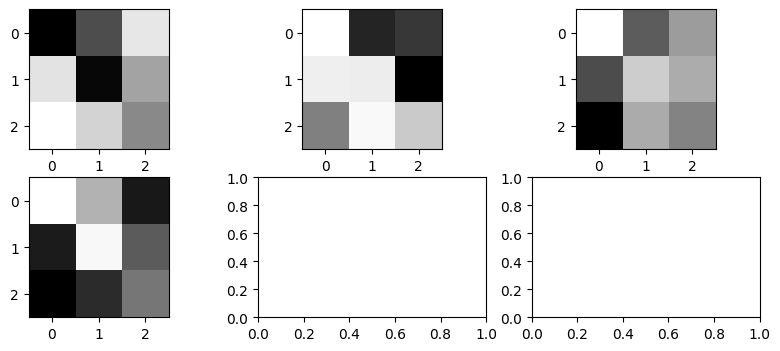

In [25]:
print(model.layers[2].get_weights()[0].shape)
print(model.layers[4].get_weights()[0].shape)
print(model.layers[6].get_weights()[0].shape)

lay = 4

percented = (model.layers[lay].get_weights()[0] / model.layers[lay].get_weights()[0].sum())
print(percented.shape)

print(model.layers[lay].get_weights()[0][:,:,0,0])
print(percented[:,:,0,0])

fig, axarr = plt.subplots(2, 3, figsize=(10, 4))
axarr[0,0].imshow(model.layers[lay].get_weights()[0][:,:,0,0], cmap='gray')
axarr[0,1].imshow(model.layers[lay].get_weights()[0][:,:,1,0], cmap='gray')
axarr[0,2].imshow(model.layers[lay].get_weights()[0][:,:,2,0], cmap='gray')
axarr[1,0].imshow(percented[:,:,0,0], cmap='gray')

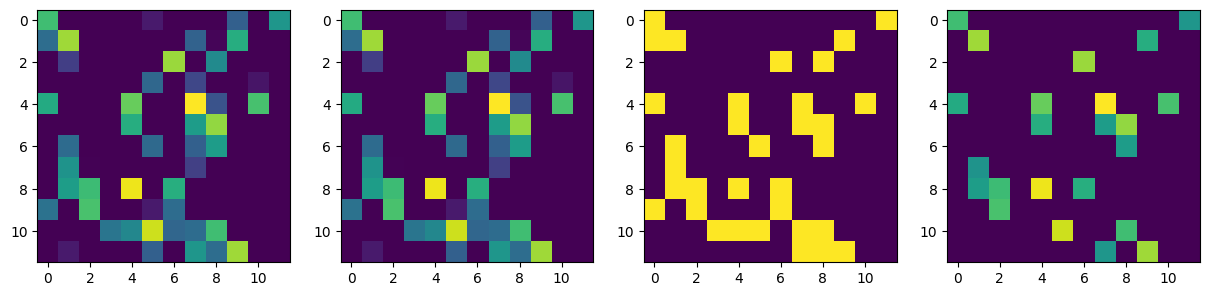

In [61]:
th = 26.29
thpercent = 0.5

mmat = np.reshape(np.resize(meanst1all[10][0], (144)), (12, 12))

percented = (meanst1all[10][0].numpy() / meanst1all[10][0].numpy().max()) # sum
mmat2 = np.reshape(np.resize(percented, (144)), (12, 12))

mmat3 = mmat.copy()
mmat3[mmat <= th] = 0
mmat3[mmat > th] = 1

mmat4 = mmat2.copy()
mmat4[mmat2 <= thpercent] = 0
#mmat4[mmat2 > thpercent] = 1

mmat5 = mmat2.copy()
mmat5[mmat2 <= thpercent] = 0

fig, axarr = plt.subplots(1, 4, figsize=(15, 5))
axarr[0].imshow(mmat)
axarr[1].imshow(mmat2)
axarr[2].imshow(mmat3)
axarr[3].imshow(mmat4)
axarr[3].imshow(mmat5)

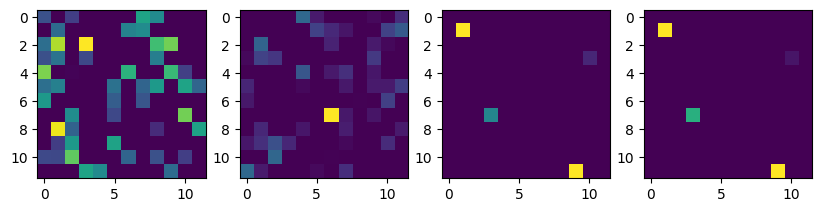

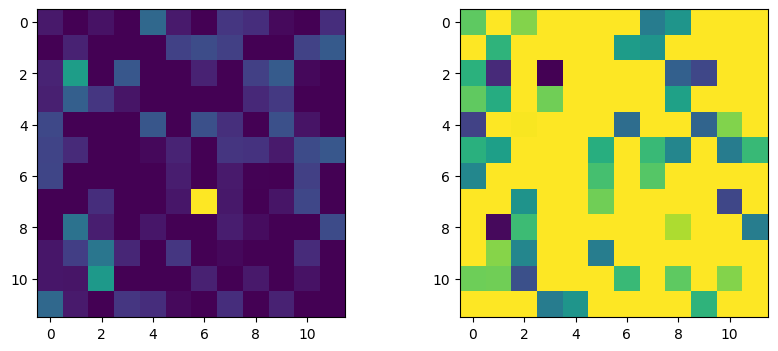

In [24]:
fig, axarr = plt.subplots(1, 4, figsize=(10, 4))
mat1 = np.reshape(np.resize(meanst1[10][0], (144)), (12, 12))
mat2 = np.reshape(np.resize(meanst2[10][0], (144)), (12, 12))
mat3 = np.reshape(np.resize(meanst31[10][0], (144)), (12, 12))
mat4 = np.reshape(np.resize(meanst32[10][0], (144)), (12, 12))
axarr[0].imshow(mat1)
axarr[1].imshow(mat2)
axarr[2].imshow(mat3)
axarr[3].imshow(mat4)
plt.show()

diff_u = mat1 + mat2
diff_mat2 = mat1 * -1
#multpld_mat = np.multiply(mat2, diff_mat)
fig, axarr = plt.subplots(1, 2, figsize=(10, 4))
axarr[0].imshow(diff_u)
axarr[1].imshow(diff_mat2)
plt.show()

In [38]:
meanst1all[2][0].shape

TensorShape([128, 128, 16])

In [77]:
per_filter_index = tot > med
mem_index = np.array([filter_index * 1.0 for filter_index in per_filter_index])
#mem_index = np.reshape(mem_index, (3,3,3,16))

In [87]:
tot

array([3.6203262e+03, 2.6822229e+04, 6.4217121e+04, 1.0602372e+04,
       1.2052476e+04, 1.6861554e+03, 7.2256664e+04, 2.7287377e+04,
       4.1265439e-02, 2.4190247e+03, 2.4805602e+04, 8.9495172e+04,
       3.1686577e+03, 5.4692883e+04, 1.0920461e+04, 1.8925664e+03],
      dtype=float32)

In [88]:
1 - pct

array([0.9595472 , 0.70029414, 0.28245157, 0.88153136, 0.8653282 ,
       0.98115927, 0.19261944, 0.6950967 , 0.9999995 , 0.9729703 ,
       0.7228275 , 0.        , 0.96459407, 0.3888734 , 0.8779771 ,
       0.97885287], dtype=float32)

In [72]:
arr = meanst1all[2][0].numpy()
tot = arr.reshape(-1, arr.shape[-1]).sum(axis=0)
pct = (tot / tot.max())
med = np.percentile(tot, 50)
print(tot > med)
print(pct > 0.5)

[False  True  True False  True False  True  True False False  True  True
 False  True False False]
[False False  True False False False  True False False False False  True
 False  True False False]


In [ ]:
for l in cnn_layers:
	print_filters_2d(model.layers[l].get_weights()[0])

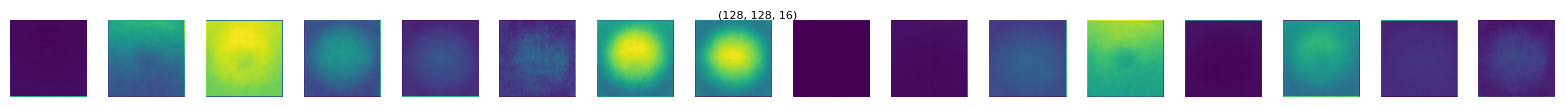

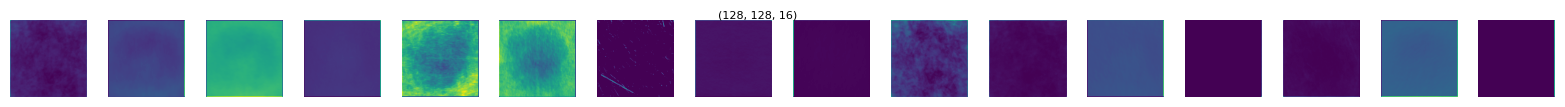

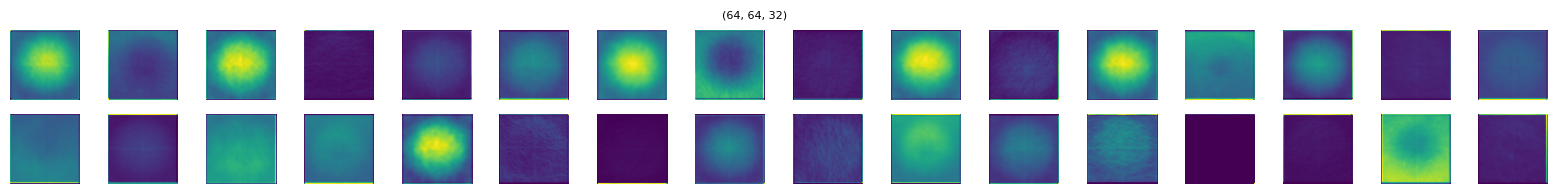

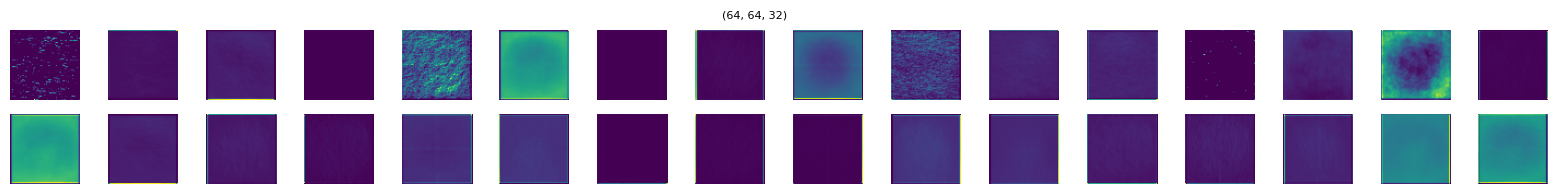

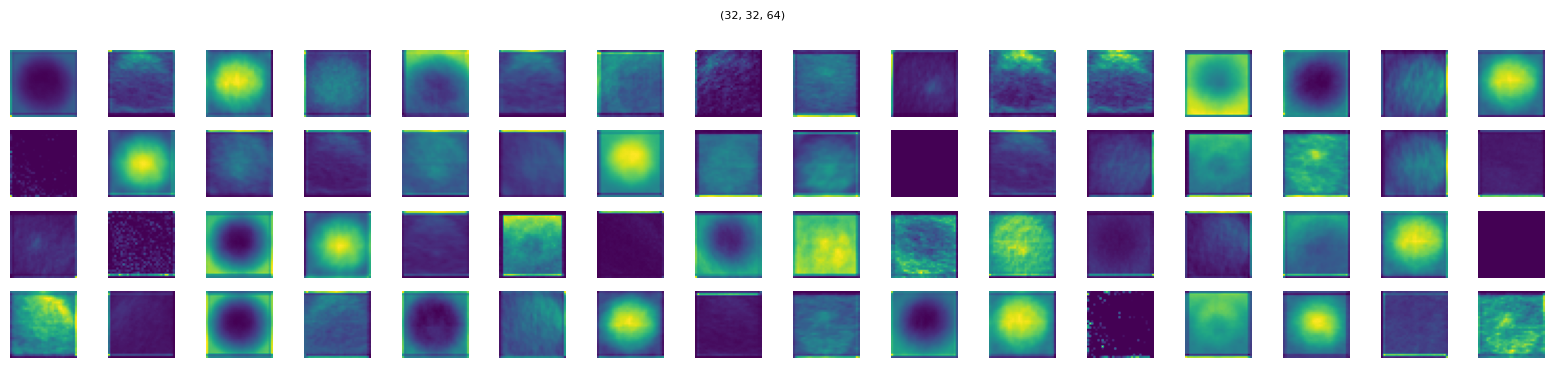

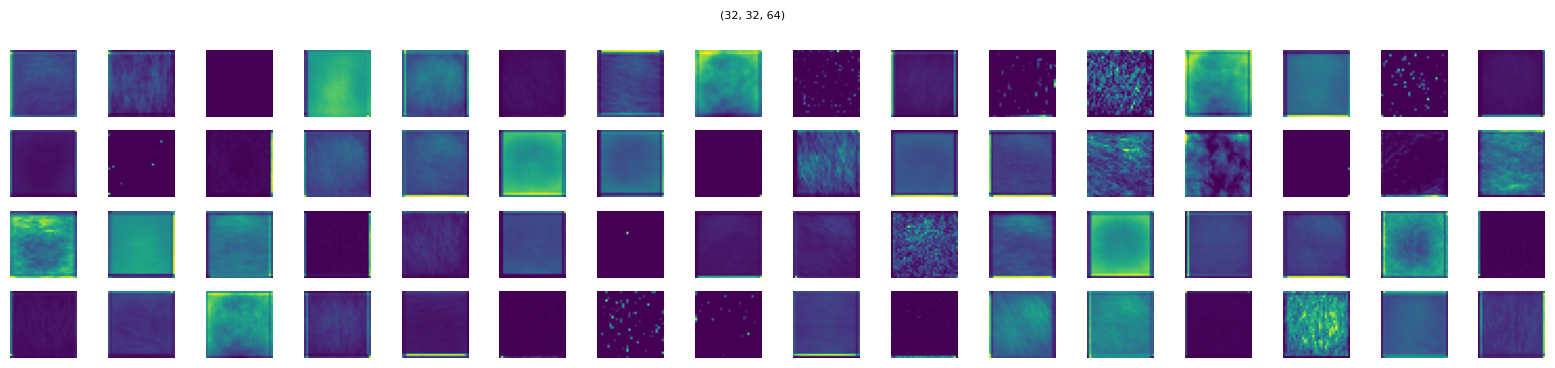

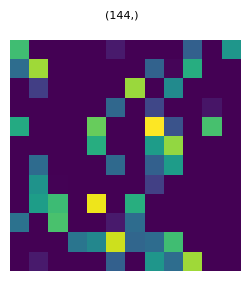

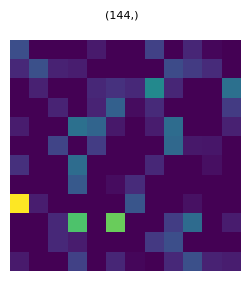

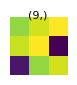

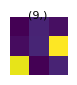

In [71]:
for l in all_layers:
    ftrs = meanst1all[l][0]
    ftrs2 = meanst2all[l][0]
    
    if len(ftrs.shape) == 1:
        print_filters_1d(ftrs)
        print_filters_1d(ftrs2)
    elif len(ftrs.shape) == 3:
        print_filters_3d(ftrs)
        print_filters_3d(ftrs2)

# Sleep

In [17]:
def one_pass(model, ds_reminder, thresholds):
    for x, y in ds_reminder:
        for i in range(1, len(x)+1):
            out = x[i-1:i]
            activations = []
            outs = [out]

            # forward
            for l in range(len(model.layers)):
                out = model.layers[l](out)
                if len(model.layers[l].get_weights()) > 0:
                    outs.append(out)
                    #print(out.shape)
                    if len(out.shape) > 2: # cnn
                        a = np.sum(out, axis=(0,1,2))
                        #neurons_med = np.mean(out, axis=(0,1,2))
                        #a = np.count_nonzero(out > neurons_med, axis=(0,1,2))
                    else: # dnn
                        a = out.numpy()[0].copy()
                    a[a <= thresholds[l]] = 0.0
                    a[a > thresholds[l]] = 1.0
                    activations.append(a)
            break
        break

    return activations, outs

def custom_sleep(model, ds_reminder, thresholds, epochs=30, inc=0.01, dec=0.001):
    f = IntProgress(min=0, max=epochs)
    display(f)
    
    for epoch in range(epochs):
        for x, y in ds_reminder:
            for i in range(1, len(x)+1):
                out = x[i-1:i]
                activations = []
                activation_layers = []
                
                # forward
                for l in range(len(model.layers)):
                    out = model.layers[l](out)
                    if len(model.layers[l].get_weights()) > 0:
                        #print(out.shape)
                        if len(out.shape) > 2: # cnn
                            a = np.sum(out, axis=(0,1,2))
                            #neurons_med = np.mean(out, axis=(0,1,2))
                            #a = np.count_nonzero(out > neurons_med, axis=(0,1,2))
                        else: # dnn
                            a = out.numpy()[0].copy()
                        a[a <= thresholds[l]] = 0.0
                        a[a > thresholds[l]] = 1.0
                        activations.append(a)
                        activation_layers.append(l)
                    
                # backward
                for a in range(1, len(activations)):
                    layer_index = activation_layers[a]
                    prev_layer_index = activation_layers[a-1]
                    
                    #print('layer, prev', layer_index, prev_layer_index)
                    #print('a w', model.layers[layer_index].get_weights()[0].shape)
                    #print('a', activations[a])
                    #print('a-1', activations[a - 1])
                    
                    weights = model.layers[layer_index].get_weights().copy()
                    prev_weights = model.layers[prev_layer_index].get_weights() # no copy

                    for a_n in range(len(activations[a])): # activation of neuron
                        #print(a_n, activations[a][a_n])
                        if activations[a][a_n] > 0: # only operates for 1-0 and 1-1
                            updates = activations[a][a_n] * activations[a - 1] # only 1-1 are incremented
                            #print('upd', updates)
                            upd_incs = updates * inc
                            upd_decs = (~(updates.astype(bool))).astype(float) * dec # everything else is decremented
                            #print(upd_incs)
                            #print(upd_decs)
                            #print('--')
                        
                            if len(weights[0].shape) > 2: # cnn
                                weights[0][:,:,:,a_n] = weights[0][:,:,:,a_n] + upd_incs - upd_decs # change only weights, not bias
                            else: # dnn
                                if prev_weights[0].shape[-1] != weights[0].shape[0]: # first dnn after flatten
                                    flat_size = weights[0].shape[0] / prev_weights[0].shape[-1]
                                    upd_incs = np.repeat(upd_incs, flat_size)
                                    upd_decs = np.repeat(upd_decs, flat_size)
                                    
                                weights[0][:,a_n] = weights[0][:,a_n] + upd_incs - upd_decs # change only weights, not bias
                            
                    model.layers[layer_index].set_weights(weights)
                
        f.value += 1

## Sleep tests

In [18]:
def get_activations(model, mean_output):
    activations = []
    for i in range(len(model.layers)):
        if i in all_layers:
            activations.append(mean_output[i][0].numpy())
        #else:
        #    activations.append(None)
    return np.array(activations)

In [19]:
global_grads = None

In [20]:
%%time
model1 = generate_model(total_label)
opti_fn1 = tf.keras.optimizers.Adam()
loss_fn1 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
history1 = custom_training(model1, opti_fn1, loss_fn1, train_flw, 10)
custom_evaluate(model1, loss_fn1, train_flw)

IntProgress(value=0, max=10)

CPU times: total: 15min 49s
Wall time: 5min 20s


(0.62539154, 0.7632834)

In [ ]:
%%time
model2 = generate_model(total_label)
opti_fn2 = tf.keras.optimizers.Adam()
loss_fn2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
history2 = custom_training(model2, opti_fn2, loss_fn2, train_cat, 10)
custom_evaluate(model2, loss_fn2, train_cat)

IntProgress(value=0, max=10)

CPU times: total: 10min 13s
Wall time: 3min 38s


(0.47077936, 0.782)

In [25]:
%%time
model3 = generate_model(total_label)
opti_fn3 = tf.keras.optimizers.Adam()
loss_fn3 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
history3 = custom_training(model3, opti_fn3, loss_fn3, train_cat_join, 10)
custom_evaluate(model3, loss_fn3, train_cat_join)

IntProgress(value=0, max=10)

CPU times: total: 10min 7s
Wall time: 3min 47s


(0.45678508, 0.7845)

In [26]:
%%time
model4 = generate_model(total_label)
opti_fn4 = tf.keras.optimizers.Adam()
loss_fn4 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
history4 = custom_training(model4, opti_fn4, loss_fn4, train_flw_and_cat, 10)
print(custom_evaluate(model4, loss_fn4, train_flw))
print(custom_evaluate(model4, loss_fn4, train_cat_join))
custom_evaluate(model4, loss_fn4, train_flw_and_cat)

IntProgress(value=0, max=10)

(1.0546476, 0.61580384)
(0.7320463, 0.688)
CPU times: total: 25min 41s
Wall time: 9min 50s


(0.9228158, 0.6450567)

In [ ]:
meansout3t1, _ = get_mean_output(model3, train_flw, all_layers)

In [107]:
tts = get_threshold_activation(model1, train_flw, all_layers)

IntProgress(value=0, max=92)

{2: nan, 4: nan, 6: nan, 10: 4591.666177213192, 11: 8945.771550178528}


In [108]:
tts

{2: nan, 4: nan, 6: nan, 10: 1.563918997688417, 11: 3.0469249149109427}

In [95]:
act_freq, raw_freq = get_activation_frequency(model1, train_flw, all_layers, tts)

IntProgress(value=0, max=92)

ds_size 2936 len(dataset) 92


In [93]:
act_freq2, raw_freq2 = get_activation_frequency(model1, train_cat_join, all_layers, tts)

IntProgress(value=0, max=63)

ds_size 2000 len(dataset) 63


In [96]:
act_freq

{2: array([0.9955722 , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.97888285, 0.9976158 , 0.9993188 ,
        1.        , 1.        , 1.        , 0.9993188 , 0.9870572 ,
        1.        ], dtype=float32),
 4: array([0.9223433 , 0.95538145, 1.        , 1.        , 0.8242507 ,
        0.96491826, 0.07901908, 0.998297  , 0.996594  , 0.9138283 ,
        0.98739785, 0.991485  , 0.97036785, 0.994891  , 1.        ,
        0.9870572 , 1.        , 1.        , 0.9904632 , 0.9911444 ,
        0.996594  , 0.886921  , 1.        , 1.        , 0.98194826,
        0.9996594 , 0.9996594 , 0.9996594 , 0.78950953, 0.8004087 ,
        0.99080384, 1.        ], dtype=float32),
 6: array([0.9352861 , 0.979564  , 0.991485  , 0.9008856 , 0.880109  ,
        0.96900547, 0.73739785, 0.9925068 , 0.9407357 , 0.883515  ,
        0.9993188 , 0.77656674, 0.967643  , 0.7561308 , 0.9192779 ,
        0.92711174, 0.02077657, 0.94788826, 0.9771798 , 0.62772477,
        0.26805177, 0

In [ ]:
#tts
#tts_raw
act_freq
#raw_freq

In [ ]:
same = train_flw.shuffle(32).take(30)
res1, out1 = one_pass(model3, same, tts)
res2, out2 = one_pass(model4, same, tts4)
print(res1)
print(out1[5])
print(res2)
print(out2[5])

In [82]:
model34 = tf.keras.models.clone_model(model3)
model34.set_weights(model3.get_weights())

custom_sleep(model34, train_flw.take(30), tts, epochs=1, inc=0.0001, dec=0.0)#inc=0.01, dec=0.001)

IntProgress(value=0, max=1)

In [83]:
print('Old', custom_evaluate(model3, loss_fn, train_flw))
print('Old N NEW', custom_evaluate(model3, loss_fn, train_cat_join))

print('New', custom_evaluate(model34, loss_fn, train_flw))
print('New N NEW', custom_evaluate(model34, loss_fn, train_cat_join))

Old (0.73474294, 0.7166213)
Old N NEW (9.488225, 0.0)
New (20036.916, 0.1863079)
New N NEW (41922.16, 0.0)


In [ ]:
com dec, de 71 caiu pra 69
com dec e inc, de 71 caiu pra 30
com inc, de 71 caiu pra 18

In [86]:
model35 = tf.keras.models.clone_model(model34)
model35.set_weights(model34.get_weights())

historyl35 = custom_training(model35, tf.keras.optimizers.Adam(), loss_fn, train_cat_join, 10)

IntProgress(value=0, max=10)

In [88]:
print('New', custom_evaluate(model35, loss_fn, train_flw))
print('New N NEW', custom_evaluate(model35, loss_fn, train_cat_join))

New (146.21915, 0.0)
New N NEW (0.6809491, 0.587)


In [23]:
%%time
model4 = generate_model(total_label)
history4 = custom_training(model4, tf.keras.optimizers.Adam(), loss_fn, train_cat_join, 10)

IntProgress(value=0, max=10)

CPU times: total: 9min 10s
Wall time: 3min 36s


In [90]:
print('New', custom_evaluate(model4, loss_fn, train_flw))
print('New N NEW', custom_evaluate(model4, loss_fn, train_cat_join))

New (17.344698, 0.0)
New N NEW (0.47214577, 0.782)


In [24]:
weights5 = np.sum([model3.get_weights(), model4.get_weights()], axis=(0))/2
model5 = tf.keras.models.clone_model(model3)
model5.set_weights(weights5)

C:\Users\joao\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [25]:
print('New', custom_evaluate(model5, loss_fn, train_flw))
print('New N NEW', custom_evaluate(model5, loss_fn, train_cat_join))

New (2.0153124, 0.18494551)
New N NEW (1.815456, 0.016)


In [37]:
def flattenmodel(model):
    flat = model.get_weights()[0].flatten()
    for i in range(1, len(model.get_weights())):
        flat = np.concatenate((flat, model3.get_weights()[i].flatten()))
    return flat

In [36]:
print(model3.get_weights()[0].shape)
#print(model4.get_weights()[0][:,:,:,0].flatten())
#print(model5.get_weights()[0][:,:,:,0].flatten())

(3, 3, 3, 16)


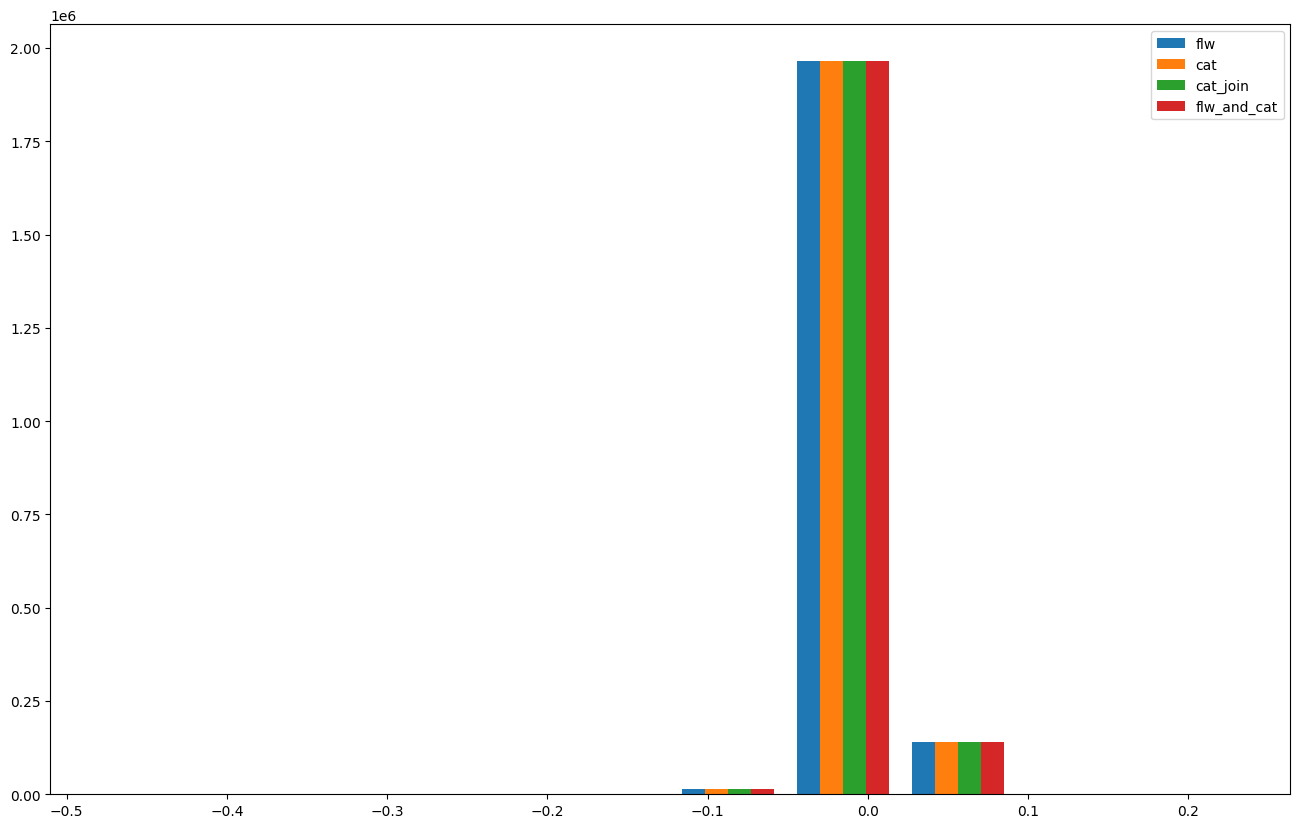

In [38]:
ind = 1
plt.figure(figsize=(16,10))
plt.hist([
    flattenmodel(model1),
    flattenmodel(model2),
    flattenmodel(model3),
    flattenmodel(model4)
    #model1.get_weights()[ind].flatten(),
    #model2.get_weights()[ind].flatten(),
    #model3.get_weights()[ind].flatten(),
    #model4.get_weights()[ind].flatten()
], label=['flw','cat','cat_join','flw_and_cat'])
plt.legend(loc='upper right')
#fig, axarr = plt.subplots(2,1, figsize=(16, 10))
#axarr[0].plot(model2.get_weights()[ind].flatten())
#axarr[1].plot(model3.get_weights()[ind].flatten())
#axarr[2].plot(model5.get_weights()[ind].flatten())

In [152]:
tts4, tts_raw4 = get_threshold_activation(model4, train_cat_join, all_layers)

IntProgress(value=0, max=63)

ds_size 2000 len(dataset) 63


In [153]:
act_freq4, raw_freq4 = get_activation_frequency(model4, train_cat_join, all_layers, tts4)

IntProgress(value=0, max=63)

ds_size 2000 len(dataset) 63


In [ ]:
ipos = 11
ipos2 = 1
dist = tts[ipos][ipos2]
#dist_val = tts[ipos][str(ipos2)+'_val']
med = np.mean(dist)#+(np.std(dist)*1)
#med_val = np.mean(dist_val)#+(np.std(dist_val)*1)
print('MAX', np.max(dist))
print('MED', med)
#print('MAX_val', np.max(dist_val))
#print('MED_val', med_val)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].hist(dist, bins=100)
ax[0].axvline(med, color='r', linewidth=1)
#ax[1].hist(dist_val, bins=100)
#ax[1].axvline(med_val, color='r', linewidth=1)
plt.plot()

In [75]:
activint1 = meansin3t1[0]
activoutt1 = get_activations(model3, meansout3t1)

C:\Users\joao\AppData\Local\Temp\ipykernel_8228\3056016646.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(activations)


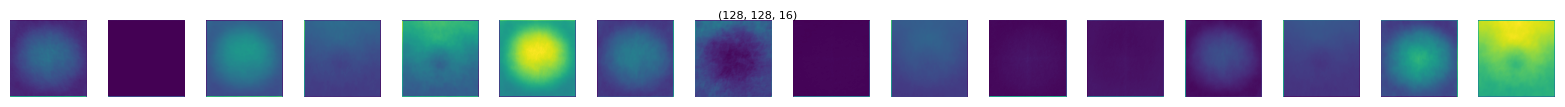

In [96]:
print_filters_3d(activoutt1[0])

MED 0.8771918


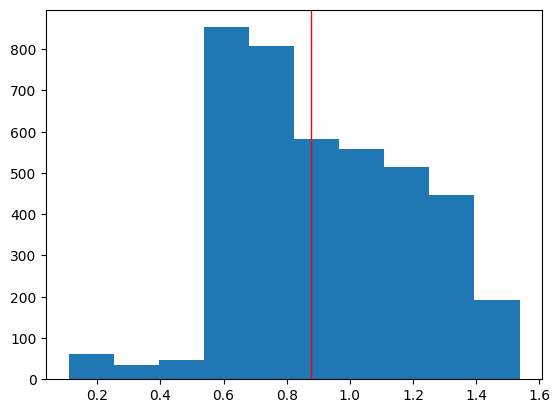

In [83]:
ipos = 10
dist = activoutt1[1][:,:,ipos].flatten()
med = np.median(dist)#-(dist.std()*1)
print('MED', med)
plt.hist(dist)
plt.axvline(med, color='r', linewidth=1)

In [58]:
#Interted dropout: output = output / drop_prob (pra manter a saida parecida quando o neuronio eh desativado) 
opti_fn2 = Memorizer(tf.keras.optimizers.Adam())
opti_fn2.integrateDNN = False
opti_fn2.memorize(activations)

model32 = tf.keras.models.clone_model(model3)
model32.set_weights(model3.get_weights())

C:\Users\joao\AppData\Local\Temp\ipykernel_1236\615933089.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.memory = np.array(memorization_indexes)


In [59]:
history32 = custom_training(model32, opti_fn2, loss_fn, train_cat_join, 10)

IntProgress(value=0, max=10)

In [48]:
print('OLD', custom_evaluate(model3, loss_fn, train_flw))
print('NEW', custom_evaluate(model32, loss_fn, train_cat_join))
print('NEW N OLD', custom_evaluate(model32, loss_fn, train_flw))

OLD (0.6987745, 0.729564)
NEW (1.9353923, 0.0)
NEW N OLD (1.8298082, 0.2527248)


In [47]:
for x, y in valid_flw.take(3):
    logits3 = model3(x[0:1,:,:,:], training=False)
    logits32 = model32(x[0:1,:,:,:], training=False)
    print(y[0].numpy(), np.argmax(logits3.numpy()[0]), np.argmax(logits32.numpy()[0]))
    print(logits3.numpy()[0])
    print(logits32.numpy()[0])

0 4 0
[ 2.9278872  3.1113522  3.150495  -1.6911155  3.6000946 -7.334844
 -6.942229 ]
[ 0.06345917 -0.5906073  -0.6147177  -0.03854511 -0.59762484 -0.31563407
 -0.4073079 ]
0 2 0
[ 2.6999142   1.4270815   6.114808    0.09021486  3.3811262  -8.903619
 -8.1092615 ]
[ 0.05957711 -0.8298311  -0.5963886   0.05631582 -0.6958753  -0.4560203
 -0.56298035]
1 1 0
[ 1.2786605   2.4608846   1.1547548   0.11033688  1.9698948  -6.469645
 -6.676598  ]
[ 0.04232191 -0.43255377 -0.50610024 -0.03800422 -0.6157082  -0.17206675
 -0.21978906]


In [60]:
means3t2, _ = get_mean_output(model32, train_cat_join, all_layers)
activations2 = get_activations(model32, means3t2)

IntProgress(value=0, max=63)

Mean calculated


C:\Users\joao\AppData\Local\Temp\ipykernel_1236\3056016646.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(activations)


In [92]:
new_weights_onlymax = []
new_weights_onlymin = []
for i in range(len(opti_fn2.memory)):
    new_weights_onlymax.append(model3.get_weights()[i] * (opti_fn2.memory[i] < 1).astype(float))
    new_weights_onlymin.append(model3.get_weights()[i] * opti_fn2.memory[i])

In [93]:
model33 = tf.keras.models.clone_model(model3)
model33.set_weights(new_weights_onlymax)
model34 = tf.keras.models.clone_model(model3)
model34.set_weights(new_weights_onlymin)

In [94]:
means33t1, _ = get_mean_output(model33, train_flw, all_layers)
activations3 = get_activations(model33, means33t1)
means33t2, _ = get_mean_output(model33, train_cat_join, all_layers)
activations4 = get_activations(model33, means33t2)

means34t1, _ = get_mean_output(model34, train_flw, all_layers)
activations5 = get_activations(model34, means34t1)
means34t2, _ = get_mean_output(model34, train_cat_join, all_layers)
activations6 = get_activations(model34, means34t2)

IntProgress(value=0, max=92)

Mean calculated


C:\Users\joao\AppData\Local\Temp\ipykernel_1236\3056016646.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(activations)


IntProgress(value=0, max=63)

Mean calculated


IntProgress(value=0, max=92)

Mean calculated


IntProgress(value=0, max=63)

Mean calculated


In [95]:
print('ONLYMAX', custom_evaluate(model33, loss_fn, train_flw))
print('ONLYMAX N NEW', custom_evaluate(model33, loss_fn, train_cat_join))

print('ONLYMIN', custom_evaluate(model34, loss_fn, train_flw))
print('ONLYMIN N NEW', custom_evaluate(model34, loss_fn, train_cat_join))

ONLYMAX (1.4657699, 0.35456404)
ONLYMAX N NEW (6.1927376, 0.0)
ONLYMIN (1.9112473, 0.29972753)
ONLYMIN N NEW (1.98636, 0.0)


In [ ]:
print_filters_3d(activations[0])
print_filters_3d(activations3[0]) # only max na T1
print_filters_3d(activations4[0]) # only max na T2
print_filters_3d(activations5[0]) # only min na T1
print_filters_3d(activations6[0]) # only min na T2
print_filters_3d(activations2[0]) # T2
#print_filters_1d(activations[4])

In [46]:
global_grads2 = global_grads.copy()
numpys = global_grads2[0].numpy()[:]
numpys[:,:,:,0] = np.zeros((3,3,3))
global_grads2[0] = tf.convert_to_tensor(numpys)

In [ ]:
fig, axarr = plt.subplots(2, 3, figsize=(10, 4))
mat1 = np.reshape(np.resize(meanst1[10][0], (144)), (12, 12))
axarr[0,0].imshow(model3.layers[10].get_weights()[0][:,:,0,0], cmap='gray')
axarr[0,1].imshow(model3.layers[10].get_weights()[0][:,:,1,0], cmap='gray')
axarr[0,2].imshow(model3.layers[10].get_weights()[0][:,:,2,0], cmap='gray')
axarr[1,0].imshow(global_grads[0][:,:,0,0], cmap='gray')
axarr[1,1].imshow(global_grads[0][:,:,1,0], cmap='gray')
axarr[1,2].imshow(global_grads[0][:,:,2,0], cmap='gray')

In [197]:
print(model.evaluate(train_flw))
print(model2.evaluate(train_cat_join))
print(model3.evaluate(train_flw))
print(model3.evaluate(train_cat_join))

92/92 [==============================] - 6s 62ms/step - loss: 0.6674 - accuracy: 0.7527
[0.6673895120620728, 0.7527247667312622]
63/63 [==============================] - 4s 60ms/step - loss: 0.5255 - accuracy: 0.7355
[0.5255239009857178, 0.7354999780654907]
92/92 [==============================] - 6s 63ms/step - loss: 17.6026 - accuracy: 0.0000e+00
[17.60260772705078, 0.0]
63/63 [==============================] - 4s 59ms/step - loss: 0.5974 - accuracy: 0.6825
[0.597402811050415, 0.6825000047683716]


In [ ]:
custom_evaluate(model3, loss_fn, valid_cat_join)

# Optimizer

In [48]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(epoch)
        print(self.model)
        

class Memorizer(tf.keras.optimizers.Optimizer):
    def __init__(self, optimizer, **kwargs):
        self.optimizer = optimizer
        super().__init__('Memorizer')
        
        self.memory = None
        self.memory_index = 0

        self.integrateCNN = False
        self.thresholdCNN = 0.5

        self.integrateDNN = True
        self.halfIntegrateDNN = False
        self.thresholdDNN = 0.7

    def memorize(self, layer_activations):
        memorization_indexes = []

        for layer in layer_activations:
            #layer = layer_activations[l]

            mem_index = None

            #if layer is None:
            #    mem_index = 1.0
                
            #elif
            if len(layer.shape) == 1: #dnn
                percented = (layer / layer.max()) #sum

                if self.integrateDNN: # integration
                    mem_index = percented.copy()
                    mem_index[mem_index < 0] = 0
                    mem_index = 1 - mem_index

                else: # segregation
                    mem_index = layer.copy()

                    mem_index[percented < self.thresholdDNN] = 0
                    if not self.halfIntegrateDNN:
                        mem_index[percented >= self.thresholdDNN] = 1
                        
            else: # cnn
                total = layer.reshape(-1, layer.shape[-1]).sum(axis=0)

                if self.integrateCNN: # integration
                    mem_index = (total / total.max())
                    mem_index[mem_index < 0] = 0
                    mem_index = 1 - mem_index

                else: # segregation
                    threshold = np.percentile(total, self.thresholdCNN*100)
                    filter_indexes = total < threshold
                    mem_index = np.array([index * 1.0 for index in filter_indexes])
            
            memorization_indexes.append(mem_index)
            memorization_indexes.append(mem_index) # one for bias

        self.memory = np.array(memorization_indexes)

    def _crop_grad(self, gradients):
        if self.memory is None:
            return gradients
        else:
            #print(gradients.shape, self.memory_index)
            new_grad = gradients.numpy() * self.memory[self.memory_index]
            self.memory_index = (self.memory_index + 1) % len(self.memory)
            return tf.convert_to_tensor(new_grad, dtype=np.float32)
            
            #new_grads = []
            #for i in range(len(gradients)):
                #new_grad = gradients[i].numpy() * self.memory[i]
                #new_grads.append(new_grad)
            #return tf.convert_to_tensor(new_grads)


    """
    Keras mandatory methods for Optimizer
    """
    def build(self, var_list):
        super().build(var_list)
        self.optimizer.build(var_list)
        if hasattr(self, "_built") and self._built:
            return
        self._built = True

    def update_step(self, gradient, variable):
        #self.optimizer().update_step(self._crop_grad(gradient), variable)
        #print('111')
        #print(gradient)
        self.optimizer.update_step(self._crop_grad(gradient), variable)
        
    @property
    def _learning_rate(self):
        return self.optimizer._learning_rate
    
    @_learning_rate.setter
    def _learning_rate(self, value):
        self.optimizer._learning_rate = value

    def get_config(self):
        config = super().get_config()
        config.update({
            "memory": self.memory,
            "optimizer": self.optimizer.get_config()
        })
        return config

In [ ]:
%%time
model6 = generate_model(total_label)
opti_fn = Memorizer(tf.keras.optimizers.Adam())
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
history6 = custom_training(model6, opti_fn, loss_fn, train_flw, 10)

In [ ]:
#Interted dropout: output = output / drop_prob (pra manter a saida parecida quando o neuronio eh desativado) 
opti_fn2 = Memorizer(tf.keras.optimizers.Adam())
opti_fn2.integrateDNN = False
opti_fn2.memorize(activations)

model32 = tf.keras.models.clone_model(model6)
model32.set_weights(model6.get_weights())

In [ ]:
print(model.evaluate(train_flw))
print(model2.evaluate(train_cat_join))
print(model3.evaluate(train_flw))
print(model3.evaluate(train_cat_join))

# Optimizer native

In [141]:
epochs=1#10
model4 = generate_model(total_label)

opti_fn = Memorizer(tf.keras.optimizers.Adam())
model4.compile(optimizer=opti_fn, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [142]:
%%time
historyt41 = model4.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=1) # callbacks=[CustomCallback()]

g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
92/92 [==============================] - 24s 248ms/step - loss: 1.3014 - accuracy: 0.4363 - val_loss: 1.0588 - val_accuracy: 0.5995
CPU times: total: 1min 21s
Wall time: 24.3 s


In [ ]:
print(model4.evaluate(train_flw))
model4.evaluate(train_cat_join)

In [ ]:
model.evaluate(train_flw)

In [ ]:
means4t1, _ = get_mean_output(model4, train_flw, all_layers)

In [ ]:
activations2 = []
for i in range(len(model4.layers)):
    if i in all_layers:
        activations2.append(means4t1[i][0].numpy())
    else:
        activations2.append(None)
activations2 = np.array(activations2)

In [143]:
model4.optimizer.memorize(activations2)

C:\Users\joao\AppData\Local\Temp\ipykernel_2456\137016010.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.memory = np.array(memorization_indexes)


In [144]:
historyt42 = model4.fit(train_cat_join, validation_data=valid_cat_join, epochs=epochs, verbose=1) # callbacks=[CustomCallback()]

63/63 [==============================] - 16s 258ms/step - loss: 1.4125 - accuracy: 0.3870 - val_loss: 0.6866 - val_accuracy: 0.5590


In [ ]:
print(model4.evaluate(train_flw))
model4.evaluate(train_cat_join)

# Regularizer

In [64]:
class MemoryRegularizer(tf.keras.regularizers.Regularizer):

    def __init__(self, memory, importance, threshold):
        self.memory = memory
        self.importance = importance
        self.threshold = threshold

    def __call__(self, x):
        #integration = self.importance.copy()
        #integration[self.importance < self.threshold] = 0
        
        diff = self.importance * tf.math.abs(self.memory - x)
        return tf.reduce_sum(diff)

    def get_config(self):
        return {'memory': self.memory, 'importance': self.importance}
    
class EWCRegularizer(tf.keras.regularizers.Regularizer):

    def __init__(self, weights, fim, lam):
        self.weights = weights
        self.fim = fim
        self.lam = lam

    def __call__(self, x):
        loss = tf.reduce_sum(self.fim * ((x - self.weights) ** 2))

        return loss * (self.lam / 2)
    
arr_regularizers1 = []
for i in range(len(importance1)):
    #arr_regularizers1.append(MemoryRegularizer(model1.trainable_variables[i].numpy(), importance1[i].numpy(), 0.9))
    arr_regularizers1.append(EWCRegularizer(model1.trainable_variables[i].numpy(), fim[i].numpy(), 1))

In [ ]:
print(importance1[1])
print(model1.trainable_variables[1])
print(model_r.trainable_variables[1])

In [65]:
%%time
model_r = generate_model(total_label)#, arr_regularizers1)
opti_fn_r = tf.keras.optimizers.Adam()
loss_fn_r = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_r.set_weights(model1.get_weights())

#model_r.compile(optimizer=opti_fn_r, loss=loss_fn_ewc)#, run_eagerly=True)
#model_r.fit(train_cat_join, epochs=10)
history_r = custom_training(model_r, opti_fn_r, loss_fn_r, train_cat_join, 10)

print('flw', custom_evaluate(model_r, loss_fn_r, train_flw))
print('cat', custom_evaluate(model_r, loss_fn_r, train_cat_join))

tf.Tensor(34.49682, shape=(), dtype=float32)
tf.Tensor(2.3592582, shape=(), dtype=float32)
tf.Tensor(1.0201948, shape=(), dtype=float32)
tf.Tensor(0.8612531, shape=(), dtype=float32)
tf.Tensor(0.8023136, shape=(), dtype=float32)
tf.Tensor(0.7653593, shape=(), dtype=float32)
tf.Tensor(0.73492026, shape=(), dtype=float32)
tf.Tensor(0.7080995, shape=(), dtype=float32)
tf.Tensor(0.69114697, shape=(), dtype=float32)
tf.Tensor(0.6579669, shape=(), dtype=float32)
flw (18.126005, 0.00034059945)
cat (0.6514969, 0.6245)
CPU times: total: 11min 1s
Wall time: 4min 6s


In [71]:
%%time

grads = None
grads_r = None
ite = 100

for _ in range(ite):
    opti_fn_r = tf.keras.optimizers.Adam()
    loss_fn_r = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    model_r = generate_model(total_label)
    model_r.set_weights(model1.get_weights())
    grad = custom_training(model_r, opti_fn_r, loss_fn_r, train_cat_join, 1)
    
    model_r = generate_model(total_label, arr_regularizers1)
    model_r.set_weights(model1.get_weights())
    grad_r = custom_training(model_r, opti_fn_r, loss_fn_r, train_cat_join, 1)
    
    if grads is None:
        grads = grad[1].numpy()
        grads_r = grad_r[1].numpy()
    else:
        grads = np.sum((grads, grad[1]), axis=0)
        grads_r = np.sum((grads_r, grad_r[1]), axis=0)
                
grads = grads / ite
grads_r = grads_r / ite

CPU times: total: 6min 9s
Wall time: 2min 35s


In [72]:
for i in range(16):    
    print(importance1[1][i].numpy(), '\t', grads[i], '\t', grads_r[i])

0.54508674 	 3.6059175 	 3.4601715
0.44221097 	 0.6770854 	 0.46726802
0.21195507 	 8.66679 	 8.600129
0.55456984 	 -0.2641836 	 -0.29862115
0.0 	 0.7888091 	 0.7969687
0.5484606 	 1.3987583 	 1.3639168
0.6878009 	 -3.741113 	 -3.6195583
0.31106812 	 -7.0830336 	 -6.891708
0.2700265 	 -5.2517247 	 -5.3553524
0.98959154 	 -9.909432e-05 	 -0.00012136408
0.98264885 	 -0.02232032 	 -0.021633001
0.4958498 	 1.6274861 	 1.6484951
0.5415064 	 -2.2077153 	 -1.9929705
0.5557984 	 3.4441423 	 3.6081543
0.6398995 	 2.3842232 	 2.323666
0.13145792 	 -5.7475777 	 -5.9008527


# Loss based

In [71]:
%%time
model1 = generate_model(total_label)
opti_fn1 = tf.keras.optimizers.Adam()
loss_fn1 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
history1 = custom_training(model1, opti_fn1, loss_fn1, train_flw, 10)
custom_evaluate(model1, loss_fn1, train_flw)

tf.Tensor(1.4442058, shape=(), dtype=float32)
tf.Tensor(1.1053954, shape=(), dtype=float32)
tf.Tensor(1.0208765, shape=(), dtype=float32)
tf.Tensor(0.9425856, shape=(), dtype=float32)
tf.Tensor(0.87081766, shape=(), dtype=float32)
tf.Tensor(0.83249265, shape=(), dtype=float32)
tf.Tensor(0.79195, shape=(), dtype=float32)
tf.Tensor(0.7526273, shape=(), dtype=float32)
tf.Tensor(0.7357815, shape=(), dtype=float32)
tf.Tensor(0.7038627, shape=(), dtype=float32)
CPU times: total: 15min 51s
Wall time: 6min 35s


(0.65423495, 0.7459128)

In [19]:
%%time
model2 = tf.keras.models.clone_model(model1)
model2.set_weights(model1.get_weights())
custom_training(model2, tf.keras.optimizers.Adam(), loss_fn1, train_cat_join, 10)
print('flw', custom_evaluate(model2, loss_fn1, train_flw))
print('cat', custom_evaluate(model2, loss_fn1, train_cat_join))

tf.Tensor(1.4363482, shape=(), dtype=float32)
tf.Tensor(0.70217615, shape=(), dtype=float32)
tf.Tensor(0.68838805, shape=(), dtype=float32)
tf.Tensor(0.6643234, shape=(), dtype=float32)
tf.Tensor(0.64211524, shape=(), dtype=float32)
tf.Tensor(0.6138879, shape=(), dtype=float32)
tf.Tensor(0.6007433, shape=(), dtype=float32)
tf.Tensor(0.5815197, shape=(), dtype=float32)
tf.Tensor(0.55460095, shape=(), dtype=float32)
tf.Tensor(0.55373913, shape=(), dtype=float32)
flw (15.725485, 0.0)
cat (0.5143645, 0.7415)


In [16]:
def loss_importance(model, loss, ds_train):    
    f = IntProgress(min=0, max=len(ds_train))
    display(f)
    
    avg_delta = None
    max_delta = None
    min_delta = None
    
    for x, y in ds_train:
        with tf.GradientTape(persistent=True) as tape:
            logits = model(x, training=True)
            loss_value = loss(y, logits)

        grads = tape.gradient(loss_value, model.trainable_weights)
        del tape
        
        #print(grads[1][0])
        #avg_delta = np.absolute(grads) if avg_delta is None else avg_delta + np.absolute(grads)
        #max_delta = grads.copy() if max_delta is None else np.max((max_delta, grads), axis=0)
        #min_delta = grads.copy() if min_delta is None else np.min((min_delta, grads), axis=0)
        if avg_delta is None:
            avg_delta = np.absolute(grads)
            max_delta = grads.copy()
            min_delta = grads.copy()
        else:
            for i in range(len(grads)):
                avg_delta[i] = avg_delta[i] + np.absolute(grads[i])
                max_delta[i] = np.max((max_delta[i], grads[i]), axis=0)
                min_delta[i] = np.min((min_delta[i], grads[i]), axis=0)
        
        f.value += 1
    
    avg_delta = avg_delta / len(ds_train)
    
    diff_delta = np.absolute(np.absolute(max_delta) - np.absolute(min_delta))
    
    variation_delta = avg_delta + diff_delta
    
    max_scale = 0
    for i in range(len(variation_delta)):
        max_scale = np.max((max_scale, np.max(variation_delta[i])))
    print('max_scale', max_scale)
        
    importance = 1 - (variation_delta / max_scale)
    
    return importance #min_delta, avg_delta, max_delta, diff_delta, variation_delta, importance

In [25]:
def fisher_matrix(model, dataset, samples):
    #inputs, labels = dataset
    weights = model.trainable_weights
    variance = [tf.zeros_like(tensor) for tensor in weights]

    for data, y in dataset:
    #for _ in range(samples):
        # Select a random element from the dataset.
        #index = np.random.randint(len(inputs))
        #data = inputs[index]

        # When extracting from the array we lost a dimension so put it back.
        #data = tf.expand_dims(data, axis=0)

        # Collect gradients.
        with tf.GradientTape() as tape:
            output = model(data)
            log_likelihood = tf.math.log(output)

        gradients = tape.gradient(log_likelihood, weights)

        # If the model has converged, we can assume that the current weights
        # are the mean, and each gradient we see is a deviation. The variance is
        # the average of the square of this deviation.
        variance = [var + (grad ** 2) for var, grad in zip(variance, gradients)]

    fisher_diagonal = [tensor / samples for tensor in variance]
    return fisher_diagonal

In [27]:
%%time
importance1 = loss_importance(model1, loss_fn1, train_flw)

IntProgress(value=0, max=92)

C:\Users\joao\AppData\Local\Temp\ipykernel_13776\1526743982.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_delta = np.absolute(grads)


max_scale 1.3440511226654053
CPU times: total: 1min 20s
Wall time: 33.2 s


C:\Users\joao\AppData\Local\Temp\ipykernel_13776\1526743982.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_delta = np.absolute(np.absolute(max_delta) - np.absolute(min_delta))


In [28]:
%%time
fim = fisher_matrix(model1, train_flw, len(train_flw))

CPU times: total: 1min 20s
Wall time: 27.8 s


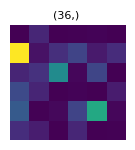

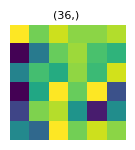

In [57]:
ih = 3
print_filters_1d(fim[ih])
print_filters_1d(importance1[ih])

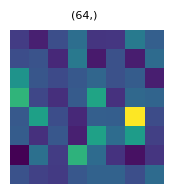

In [31]:
print_filters_1d(model1.trainable_variables[5].numpy())

In [32]:
model1.trainable_variables[5]

<tf.Variable 'conv2d_2/bias:0' shape=(64,) dtype=float32, numpy=
array([-0.03353756, -0.04604175, -0.02445207, -0.00713469, -0.03655549,
       -0.03623224,  0.00026897, -0.01540225, -0.02514592, -0.02220115,
       -0.04241177, -0.00078317, -0.04837045, -0.02314872, -0.04710767,
       -0.00854818,  0.01491628, -0.02059231, -0.02664449, -0.01946316,
       -0.01165095, -0.02339927, -0.01720336, -0.04645482,  0.03451153,
       -0.02834052, -0.03963908, -0.01762342,  0.02452312, -0.03831479,
       -0.01034933, -0.01283429, -0.01850641,  0.02255552, -0.02499754,
       -0.04233032, -0.01518083, -0.01577322,  0.08414413, -0.02537019,
       -0.01738778, -0.03880379, -0.02017025, -0.04639821,  0.02326605,
       -0.00827558,  0.02040807, -0.03155111, -0.05867277, -0.0057663 ,
       -0.03348443,  0.03379712, -0.00850638, -0.03779543, -0.05210856,
       -0.03654263, -0.02272258, -0.03100252, -0.03453909, -0.01988064,
       -0.01359475, -0.01394608, -0.02461077, -0.00890964], dtype=float

In [ ]:
mind[1] # min

In [ ]:
avgd[1] # avg

In [ ]:
maxd[1] # max

In [ ]:
difd[1] # diff

In [ ]:
vard[1] # variational

In [ ]:
importance[1] # scaled

In [18]:
def discharge2(threshold, impd, mind, maxd):
    grads = []
    for l in range(len(impd)):
        mask = (impd[l] >= threshold).numpy().astype(float)
        lim_min = np.ones(impd[l].shape) * -0.01
        lim_max = np.ones(impd[l].shape) * 0.01
        delta = random.uniform(lim_min, lim_max)#(mind[l], maxd[l])
        grad = (impd[l].numpy() * delta * mask).astype('float32')
        grads.append(grad)
    return grads

def discharge(threshold, importance, new_w, old_w):
    grads = []
    for l in range(len(importance)):
        mask = (importance[l] >= threshold).numpy().astype(float)
        diff = old_w[l] - new_w[l]
        updates = np.zeros(importance[l].shape)
        updates[diff > 0] = -0.0001 # yes its inversed
        updates[diff < 0] = 0.0001
        grad = (updates * mask).astype('float32')
        #if l == 1:
        #    print(diff)
        #    print(grad)
        #    print('--')
        grads.append(grad)
    return grads
        
def stimulate(epochs, model, optimizer, importance, old_w):
    #old_w = model.trainable_variables.copy()
    for _ in range(epochs):
        threshold = np.round(random.triangular(0.5, 0.95, 0.8), decimals=3)
        grads = discharge(threshold, importance, model.trainable_variables, old_w)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
def integrate(arr_models, arr_importances):
    summed_x_w = []
    summed_w = []
    for i in range(len(arr_models)):
        model_vars = arr_models[i].trainable_variables
        for v in range(len(model_vars)):
            if v > (len(summed_x_w)-1):
                summed_x_w.append(model_vars[v]*arr_importances[i][v])
                summed_w.append(arr_importances[i][v].numpy().copy())
            else:
                summed_x_w[v] += model_vars[v]*arr_importances[i][v]
                summed_w[v] += arr_importances[i][v]
                
    weighted_mean = []
    for v in range(len(summed_x_w)):
        weighted_mean.append(summed_x_w[v]/summed_w[v])
    return weighted_mean

In [65]:
0.00809416 > 0.1

False

In [48]:
import decimal

In [61]:
decimal.Decimal(old_w[1])#.as_tuple()

TypeError: conversion from ResourceVariable to Decimal is not supported

In [76]:
print(importance1[1])
aa = (1 - importance1[1]) * np.absolute(old_w[1] - model2.trainable_variables[1])
print(aa)
print(np.sum(aa))

tf.Tensor(
[0.803632   0.63665587 0.6673826  0.6006272  0.10854274 0.33986533
 0.08609033 0.20146012 0.72899914 0.6709542  0.6897926  0.57689786
 0.51696634 0.693719   0.15873927 0.53485847], shape=(16,), dtype=float32)
tf.Tensor(
[2.45022401e-03 5.12263272e-03 8.52802186e-04 1.39188571e-02
 1.20267468e-02 1.55997705e-02 4.93378611e-03 1.40609834e-02
 7.30656413e-03 3.68058478e-04 3.29410401e-03 6.90917732e-05
 1.77203782e-03 9.13237978e-04 6.80930028e-03 1.69543345e-02], shape=(16,), dtype=float32)
0.10645253


In [32]:
custom_evaluate(model1, loss_fn1, train_flw)

(0.60658157, 0.7717984)

In [33]:
old_w = model1.trainable_variables.copy()

In [34]:
# SAME RESULTS

model1new = tf.keras.models.clone_model(model1)
model1new.set_weights(model1.get_weights())
# opti_fn1
# tf.keras.optimizers.Adam()
# tf.keras.optimizers.legacy.Adam()
stimulate(10, model1new, tf.keras.optimizers.Adam(), importance1, old_w)
custom_evaluate(model1new, loss_fn1, train_flw)

(0.6064386, 0.7717984)

In [20]:
importance2 = loss_importance(model2, loss_fn1, train_cat_join)

IntProgress(value=0, max=63)

C:\Users\joao\AppData\Local\Temp\ipykernel_13776\1526743982.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_delta = np.absolute(grads)


max_scale 1.8715873956680298


C:\Users\joao\AppData\Local\Temp\ipykernel_13776\1526743982.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_delta = np.absolute(np.absolute(max_delta) - np.absolute(min_delta))


In [46]:
p1 = 0.05919062
i1 = 0.94744647
p2 = 0.06904178
i2 = 0.86417174
p3 = 0.06612809
i3 = 0.98770992

#i3 = 0.90772305
#i4 = 0.85417174

In [48]:
((p1*i1)+(p2*i2)+(p3*i3))/(i1+i2+i3)

0.06467954495033112

In [50]:
((p1*i1)+(p2*i2))/(i1+i2)

0.06388978565820919

In [49]:
a2 = (p1 - p2)*(i2/(i1+i2))
p2 + a2

0.06434261434179081

In [28]:
idx = 3
print(importance1[idx])
print(importance2[idx])
print(model1.trainable_variables[idx])
print(model2.trainable_variables[idx])

tf.Tensor(
[0.6878943  0.48212928 0.69660366 0.45381093 0.06041491 0.52729344
 0.90108836 0.5140666  0.8278791  0.4224335  0.7666081  0.8846745
 0.70873255 0.7820503  0.76581    0.88827324 0.9993488  0.9004093
 0.7298039  0.26768792 0.35595828 0.7924788  0.3773328  0.39124978
 0.44681484 0.46211278 0.38046354 0.6337596  0.6139921  0.85857403
 0.55468214 0.6091802 ], shape=(32,), dtype=float32)
tf.Tensor(
[0.9979795  0.8896693  0.9549767  0.9705698  0.8606274  0.85119176
 0.9907432  0.87270176 0.9981331  0.7427976  0.9460308  0.9037231
 0.9826428  0.95360297 0.9388216  0.9566167  1.         0.9379497
 0.91455966 0.99013805 0.9953718  0.9232495  0.7249705  0.94688725
 0.9509966  0.95859176 0.99769497 0.99432206 0.9979641  0.96040404
 0.8718475  0.9557898 ], shape=(32,), dtype=float32)
<tf.Variable 'conv2d_1/bias:0' shape=(32,) dtype=float32, numpy=
array([-0.03366677, -0.00817433, -0.07770433, -0.02601089, -0.00017797,
       -0.02552163, -0.0138722 ,  0.00829296, -0.0576654 ,  0.0663141

In [74]:
((model1.trainable_variables[idx]*importance1[idx])+(model2.trainable_variables[idx]*importance2[idx]))/(importance1[idx]+importance2[idx])

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([ 0.0224604 ,  0.02595068, -0.01609178, -0.01492643, -0.02225797,
       -0.01528055, -0.02051298, -0.00296021,  0.00659319,  0.00441245,
       -0.0432695 , -0.01703183, -0.00069636, -0.01885377, -0.03197524,
        0.00555738, -0.03891842, -0.02567785, -0.0376949 , -0.01911212,
        0.01941006, -0.00752954, -0.02415247,  0.00343196, -0.01587733,
        0.01221133, -0.02388899, -0.03589039, -0.03498331, -0.04104695,
       -0.06986252, -0.0307519 ], dtype=float32)>

In [31]:
resin = integrate([model1,model2],[importance1,importance2])
resin[idx]

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([-0.03776875,  0.00406218, -0.07186578, -0.02457446,  0.00951174,
       -0.01528568, -0.01681283,  0.01647509, -0.06368028,  0.06605811,
       -0.00949071, -0.02979861,  0.00893333, -0.00376248, -0.0266839 ,
       -0.04588351, -0.01816289, -0.04354421,  0.00024984, -0.04408738,
       -0.0011916 , -0.06522612, -0.00104784,  0.00976375, -0.0001528 ,
       -0.01914521, -0.0598652 , -0.00234849, -0.01172685, -0.00627411,
        0.02451261, -0.00297325], dtype=float32)>

In [29]:
model2new = tf.keras.models.clone_model(model2)

model2new.set_weights(model2.get_weights())
stimulate(9, model2new, tf.keras.optimizers.Adam(), importance1, old_w)

print('flw', custom_evaluate(model2new, loss_fn1, train_flw))
print('cat', custom_evaluate(model2new, loss_fn1, train_cat_join))

flw (2.502033, 0.2591962)
cat (1.3035265, 0.549)


In [32]:
model2new2 = tf.keras.models.clone_model(model2)
model2new2.set_weights(resin)

print('flw', custom_evaluate(model2new2, loss_fn1, train_flw))
print('cat', custom_evaluate(model2new2, loss_fn1, train_cat_join))

flw (2.086346, 0.15633515)
cat (1.3713641, 0.617)


In [34]:
idx = 9
print(old_w[idx])
print(model2.trainable_variables[idx])
print(model2new.trainable_variables[idx])
print(model2new2.trainable_variables[idx])

<tf.Variable 'dense_1/bias:0' shape=(7,) dtype=float32, numpy=
array([-0.03014596,  0.0703499 ,  0.01151966, -0.00508903, -0.02503552,
       -0.04585798, -0.04034689], dtype=float32)>
<tf.Variable 'dense_1/bias:0' shape=(7,) dtype=float32, numpy=
array([-0.06849872,  0.03995113, -0.02500072, -0.05004941, -0.06488002,
        0.02846628, -0.04010949], dtype=float32)>
<tf.Variable 'dense_1/bias:0' shape=(7,) dtype=float32, numpy=
array([-0.0596449 ,  0.04880495, -0.01614691, -0.04119559, -0.05602621,
        0.01961247, -0.04069972], dtype=float32)>
<tf.Variable 'dense_1/bias:0' shape=(7,) dtype=float32, numpy=
array([-0.04973637,  0.05430536, -0.00722399, -0.02823295, -0.04540715,
       -0.01010138, -0.04023271], dtype=float32)>


# Constraints

In [67]:
class CenterAround(tf.keras.constraints.Constraint):
    def __init__(self, ref_value):
        self.ref_value = ref_value

    def __call__(self, w):
        mean = tf.reduce_mean(w)
        return w - mean + self.ref_value

    def get_config(self):
        return {'ref_value': self.ref_value}

# Custom Gradient

# EWC

https://github.com/MertYILDIZ19/Continual-Learning/blob/main/Notebook.ipynb

In [ ]:
plot_model(mult_model)

## Without EWC

In [42]:
%%time
mult_model = generate_model([len(flw_class_names), len(cat_class_names)])#(total_label)
multi_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

mult_model.compile(loss={'head_1': multi_loss}, optimizer='adam', metrics={'head_1': "accuracy"})
mult_model.fit(train_flw, batch_size=BATCH_SIZE, epochs=10)

#history1 = custom_training(model1, opti_fn1, loss_fn1, train_flw, 10)
#custom_evaluate(model1, loss_fn1, train_flw)

Epoch 1/10
92/92 [==============================] - 21s 211ms/step - loss: 1.4252 - head_1_loss: 1.4252 - head_1_accuracy: 0.3532
Epoch 2/10
92/92 [==============================] - 20s 218ms/step - loss: 1.0774 - head_1_loss: 1.0774 - head_1_accuracy: 0.5743
Epoch 3/10
92/92 [==============================] - 21s 227ms/step - loss: 0.9687 - head_1_loss: 0.9687 - head_1_accuracy: 0.6270
Epoch 4/10
92/92 [==============================] - 20s 219ms/step - loss: 0.9059 - head_1_loss: 0.9059 - head_1_accuracy: 0.6505
Epoch 5/10
92/92 [==============================] - 20s 212ms/step - loss: 0.8471 - head_1_loss: 0.8471 - head_1_accuracy: 0.6768
Epoch 6/10
92/92 [==============================] - 19s 210ms/step - loss: 0.8178 - head_1_loss: 0.8178 - head_1_accuracy: 0.6907
Epoch 7/10
92/92 [==============================] - 19s 209ms/step - loss: 0.7675 - head_1_loss: 0.7675 - head_1_accuracy: 0.7037
Epoch 8/10
92/92 [==============================] - 20s 213ms/step - loss: 0.7519 - head_1

In [58]:
mult_model.evaluate(valid_flw)
mult_model.evaluate(valid_cat)

32/32 [==============================] - 2s 57ms/step - loss: 1.8802 - head_1_loss: 1.8802 - head_1_accuracy: 0.2820


[1.880184531211853, 1.880184531211853, 0.28200000524520874]

In [59]:
mult_model.compile(loss={'head_2': multi_loss}, optimizer='adam', metrics={'head_2': "accuracy"})
mult_model.fit(train_cat, batch_size=BATCH_SIZE, epochs=10)

Epoch 1/10
63/63 [==============================] - 14s 205ms/step - loss: 0.6321 - head_2_loss: 0.6321 - head_2_accuracy: 0.6535
Epoch 2/10
63/63 [==============================] - 13s 203ms/step - loss: 0.5817 - head_2_loss: 0.5817 - head_2_accuracy: 0.6905
Epoch 3/10
63/63 [==============================] - 18s 282ms/step - loss: 0.5639 - head_2_loss: 0.5639 - head_2_accuracy: 0.7080
Epoch 4/10
63/63 [==============================] - 16s 255ms/step - loss: 0.5305 - head_2_loss: 0.5305 - head_2_accuracy: 0.7335
Epoch 5/10
63/63 [==============================] - 18s 280ms/step - loss: 0.5116 - head_2_loss: 0.5116 - head_2_accuracy: 0.7495
Epoch 6/10
63/63 [==============================] - 15s 240ms/step - loss: 0.5056 - head_2_loss: 0.5056 - head_2_accuracy: 0.7460
Epoch 7/10
63/63 [==============================] - 16s 246ms/step - loss: 0.4861 - head_2_loss: 0.4861 - head_2_accuracy: 0.7630
Epoch 8/10
63/63 [==============================] - 15s 240ms/step - loss: 0.4721 - head_2

In [64]:
mult_model.compile(loss={'head_1': multi_loss}, optimizer='adam', metrics={'head_1': "accuracy"})
print(mult_model.evaluate(valid_flw))
mult_model.compile(loss={'head_2': multi_loss}, optimizer='adam', metrics={'head_2': "accuracy"})
print(mult_model.evaluate(valid_cat))

23/23 [==============================] - 2s 56ms/step - loss: 1.4861 - head_1_loss: 1.4861 - head_1_accuracy: 0.4523
[1.4861013889312744, 1.4861013889312744, 0.4523160755634308]
32/32 [==============================] - 2s 54ms/step - loss: 0.5332 - head_2_loss: 0.5332 - head_2_accuracy: 0.7430
[0.5332110524177551, 0.5332110524177551, 0.7429999709129333]


## With EWC

In [93]:
def compute_fisher_matrix(model, task_set, batch_size,task_id):

  # Build fisher matrixes dictionary: at each key it will store the Fisher matrix for a particular layer
  fisher_matrixes = {n: tf.zeros_like(p.value()) for n, p in enumerate(model.trainable_variables)}
 
  for i, (imgs, labels) in enumerate(task_set.take(batch_size)):
    # Initialize gradients storage
    with tf.GradientTape() as tape:

      # Compute the predictions (recall: we will just take the prediction from the head related to the actual task)
      preds = model(imgs)[task_id]

      # Compute the logarithm of the predictions
      ll= tf.math.log(preds)

    # Attach gradients over the log_likelihood to log_likelihood_grads
    ll_grads  = tape.gradient(ll, model.trainable_variables)

    # Compute Fisher matrix at each layer (if existing)
    for i, gradients in enumerate(ll_grads):
        if gradients != None:
            fisher_matrixes[i] += tf.math.reduce_mean(gradients ** 2, axis=0) / batch_size
 
  return fisher_matrixes

def EWC_loss(model,F,task_prev_param,Lambda, from_logits=False): 

    def custom_loss(y_true, y_pred):
        # Compute standard cross entropy loss
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
        normal_loss=loss(y_true,y_pred)

        # Compute EWC regularization term
        regularization_value=tf.constant([0.])
        for layer in range(len(F)):
            regularization_value+=tf.reduce_sum(F[layer]*(task_prev_param[layer]-model.trainable_variables[layer])**2)

        # Return the standard cross entropy loss + EWC regularization
        return normal_loss+regularization_value*Lambda
    
    return custom_loss

##
##      AQUI QUE O NEGOCIO COMECA
##
def compute_EWC2_matrix(model, loss, ds_train, task_id):
    f = IntProgress(min=0, max=len(ds_train))
    display(f)
    
    avg_delta = None
    max_delta = None
    min_delta = None
    
    for x, y in ds_train:
        with tf.GradientTape(persistent=True) as tape:
            logits = model(x, training=True)
            loss_value = loss(y, logits[task_id])

        grads = tape.gradient(loss_value, model.trainable_weights)
        del tape
        
        for g in range(len(grads)):
            if grads[g] is None:
                grads[g] = np.zeros(model.trainable_weights[g].shape)
        
        if avg_delta is None:
            avg_delta = np.absolute(grads)
            max_delta = grads.copy()
            min_delta = grads.copy()
        else:
            for i in range(len(grads)):
                avg_delta[i] = avg_delta[i] + np.absolute(grads[i])
                max_delta[i] = np.max((max_delta[i], grads[i]), axis=0)
                min_delta[i] = np.min((min_delta[i], grads[i]), axis=0)
        
        f.value += 1
    
    avg_delta = avg_delta / len(ds_train)
    #max_a = 0
    #for i in range(len(avg_delta)):
    #    max_a = np.max((max_a, np.max(np.absolute(avg_delta[i]))))
    #avg_delta = np.absolute(avg_delta) / max_a
    
    
    diff_delta = np.absolute(np.absolute(max_delta) - np.absolute(min_delta))
    #max_d = 0
    #for i in range(len(diff_delta)):
    #    max_d = np.max((max_d, np.max(np.absolute(diff_delta[i]))))
    #diff_delta = np.absolute(diff_delta) / max_d
    
    #max_w = 0
    #for i in range(len(model.trainable_weights)):
    #    max_w = np.max((max_w, np.max(np.absolute(model.trainable_weights[i]))))
    #final_weight = np.absolute(model.trainable_weights) / max_w
    
    final_delta = avg_delta + diff_delta + np.absolute(model.trainable_weights) #  + final_weight 
    
    max_scale = 0
    for i in range(len(final_delta)):
        max_scale = np.max((max_scale, np.max(final_delta[i])))
        
    importance = 1 - (final_delta / max_scale)
    #importance = avg_delta + diff_delta + final_weight
    
    return importance

def EWC2_loss(model,F,task_prev_param, from_logits=False): 

    def custom_loss(y_true, y_pred):
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
        normal_loss=loss(y_true,y_pred)

        regularization_value=tf.constant([0.])
        for layer in range(len(F)):
            regularization_value+=tf.reduce_sum(F[layer] * tf.math.abs(task_prev_param[layer]-model.trainable_variables[layer]))

        return normal_loss+regularization_value
    
    return custom_loss

In [61]:
mult_model.trainable_variables[1]

<tf.Variable 'conv2d/bias:0' shape=(16,) dtype=float32, numpy=
array([ 0.00753549, -0.0481726 , -0.0270802 , -0.02008883, -0.03875216,
       -0.02502616, -0.00666282,  0.05607014,  0.00119206, -0.02854333,
       -0.00365069, -0.03641943, -0.01077072, -0.01977797,  0.02203708,
        0.01208207], dtype=float32)>

In [13]:
%%time
mult_model = generate_model([len(flw_class_names), len(cat_class_names)])
multi_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

mult_model.compile(loss={'head_1': multi_loss}, optimizer='adam', metrics={'head_1': "accuracy"})
mult_model.fit(train_flw, batch_size=BATCH_SIZE, epochs=10)

Epoch 1/10
92/92 [==============================] - 20s 203ms/step - loss: 1.2585 - head_1_loss: 1.2585 - head_1_accuracy: 0.4775
Epoch 2/10
92/92 [==============================] - 20s 219ms/step - loss: 0.9807 - head_1_loss: 0.9807 - head_1_accuracy: 0.6161
Epoch 3/10
92/92 [==============================] - 19s 206ms/step - loss: 0.8411 - head_1_loss: 0.8411 - head_1_accuracy: 0.6744
Epoch 4/10
92/92 [==============================] - 20s 216ms/step - loss: 0.7032 - head_1_loss: 0.7032 - head_1_accuracy: 0.7360
Epoch 5/10
92/92 [==============================] - 21s 223ms/step - loss: 0.5475 - head_1_loss: 0.5475 - head_1_accuracy: 0.7963
Epoch 6/10
92/92 [==============================] - 19s 204ms/step - loss: 0.3905 - head_1_loss: 0.3905 - head_1_accuracy: 0.8648
Epoch 7/10
92/92 [==============================] - 17s 183ms/step - loss: 0.2758 - head_1_loss: 0.2758 - head_1_accuracy: 0.9002
Epoch 8/10
92/92 [==============================] - 18s 190ms/step - loss: 0.2075 - head_1

In [14]:
fim1 = compute_fisher_matrix(mult_model, train_flw, batch_size=BATCH_SIZE, task_id=0)

prev_params = [tf.identity(mult_model.trainable_variables[layer]) for layer in range(len(mult_model.trainable_variables))]

lossFim = EWC_loss(mult_model, fim1, prev_params, Lambda=100, from_logits=True)

In [94]:
fim2 = compute_EWC2_matrix(mult_model, multi_loss, train_flw, task_id=0)

lossFim2 = EWC2_loss(mult_model, fim2, prev_params, from_logits=True)

IntProgress(value=0, max=92)

C:\Users\joao\AppData\Local\Temp\ipykernel_12044\1312028458.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_delta = np.absolute(grads)
C:\Users\joao\AppData\Local\Temp\ipykernel_12044\1312028458.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_delta = np.absolute(np.absolute(max_delta) - np.absolute(min_delta))
C:\Users\joao\AppData\Local\Temp\ipykernel_12044\1312028458.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

In [ ]:
mmax = 0
new_fim = []
for i in range(len(fim1)):
    m = np.max(fim1[i])
    if m > mmax:
        mmax = m
    print(i, m)

for i in range(len(fim1)):
    new_fim.append(fim1[i] / mmax)

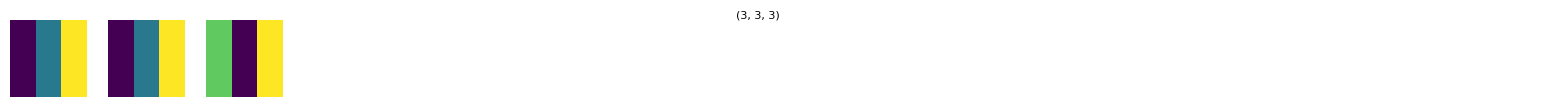

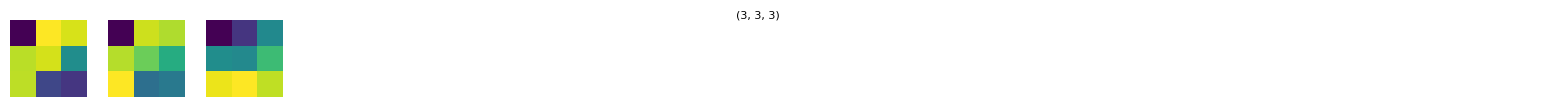

In [97]:
print_filters_3d(new_fim[0][:,:,:,3])
print_filters_3d(fim2[0][:,:,:,3])

In [16]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_model = clone_model(new_mult_model)
        test_model.compile(loss={'head_1': multi_loss}, optimizer='adam', metrics={'head_1': "accuracy"})
        test_model.evaluate(train_flw)
        del test_model

In [97]:
check_old_cb = CustomCallback()

new_mult_model = clone_model(mult_model)
#new_mult_model.compile(loss={'head_2': lossFim}, optimizer='adam', metrics={'head_2': "accuracy"})
new_mult_model.compile(loss={'head_2': lossFim2}, optimizer='adam', metrics={'head_2': "accuracy"})
#new_mult_model.compile(loss={'head_2': multi_loss}, optimizer='adam', metrics={'head_2': "accuracy"})
new_mult_model.fit(train_cat, batch_size=BATCH_SIZE, epochs=10, callbacks=[check_old_cb])

Epoch 1/10


63/63 [==============================] - 20s 303ms/step - loss: 0.6775 - head_2_loss: 0.6775 - head_2_accuracy: 0.6220
Epoch 2/10
63/63 [==============================] - 19s 298ms/step - loss: 0.5103 - head_2_loss: 0.5103 - head_2_accuracy: 0.7410
Epoch 3/10
63/63 [==============================] - 19s 300ms/step - loss: 0.3710 - head_2_loss: 0.3710 - head_2_accuracy: 0.8250
Epoch 4/10
63/63 [==============================] - 19s 302ms/step - loss: 0.2264 - head_2_loss: 0.2264 - head_2_accuracy: 0.9120
Epoch 5/10
63/63 [==============================] - 19s 301ms/step - loss: 0.1387 - head_2_loss: 0.1387 - head_2_accuracy: 0.9560
Epoch 6/10
63/63 [==============================] - 20s 311ms/step - loss: 0.1054 - head_2_loss: 0.1054 - head_2_accuracy: 0.9655
Epoch 7/10
63/63 [==============================] - 19s 301ms/step - loss: 0.0831 - head_2_loss: 0.0831 - head_2_accuracy: 0.9670
Epoch 8/10
63/63 [==============================] - 19s 300ms/step - loss: 0.0611 - head_2_loss: 0.06

EWC 2

In [31]:
new_mult_model.compile(loss={'head_1': multi_loss}, optimizer='adam', metrics={'head_1': "accuracy"})
print(new_mult_model.evaluate(train_flw))
new_mult_model.compile(loss={'head_2': multi_loss}, optimizer='adam', metrics={'head_2': "accuracy"})
print(new_mult_model.evaluate(train_cat))

92/92 [==============================] - 6s 63ms/step - loss: 0.6691 - head_1_loss: 0.6691 - head_1_accuracy: 0.8208
[0.6690846085548401, 0.6690846085548401, 0.8208447098731995]
63/63 [==============================] - 4s 61ms/step - loss: 0.0184 - head_2_loss: 0.0184 - head_2_accuracy: 0.9955
[0.018389401957392693, 0.018389401957392693, 0.9955000281333923]


EWC 1

In [28]:
new_mult_model.compile(loss={'head_1': multi_loss}, optimizer='adam', metrics={'head_1': "accuracy"})
print(new_mult_model.evaluate(train_flw))
new_mult_model.compile(loss={'head_2': multi_loss}, optimizer='adam', metrics={'head_2': "accuracy"})
print(new_mult_model.evaluate(train_cat))

92/92 [==============================] - 6s 63ms/step - loss: 1.1589 - head_1_loss: 1.1589 - head_1_accuracy: 0.7357
[1.1588577032089233, 1.1588577032089233, 0.7356948256492615]
63/63 [==============================] - 4s 62ms/step - loss: 0.0078 - head_2_loss: 0.0078 - head_2_accuracy: 0.9990
[0.007813853211700916, 0.007813853211700916, 0.9990000128746033]


Default

In [18]:
new_mult_model.compile(loss={'head_1': multi_loss}, optimizer='adam', metrics={'head_1': "accuracy"})
print(new_mult_model.evaluate(train_flw))
new_mult_model.compile(loss={'head_2': multi_loss}, optimizer='adam', metrics={'head_2': "accuracy"})
print(new_mult_model.evaluate(train_cat))

92/92 [==============================] - 6s 62ms/step - loss: 0.6507 - head_1_loss: 0.6507 - head_1_accuracy: 0.8093
[0.6506560444831848, 0.6506560444831848, 0.8092643022537231]
63/63 [==============================] - 4s 57ms/step - loss: 0.0179 - head_2_loss: 0.0179 - head_2_accuracy: 0.9965
[0.01791292428970337, 0.01791292428970337, 0.9965000152587891]


## Not working

In [161]:
def fix_this_shit(dataset, labels, minus=0):
    new_x = []
    new_y = []
    for i in range(len(dataset)):
        x = dataset[i][0]
        y = dataset[i][1]
        for j in range(len(x)):
            if y[j] in labels:
                new_x.append(x[j])
                if minus == 0:
                    new_y.append(y[j])
                else:
                    new_y.append(y[j] - minus)
    return np.array(new_x), np.array(new_y)

In [190]:
flw1_x, flw1_y = fix_this_shit(list(train_flw), [0,1,2])
flw2_x, flw2_y = fix_this_shit(list(train_flw), [3,4])

train_flw1 = tf.data.Dataset.from_tensor_slices((flw1_x, flw1_y)).batch(BATCH_SIZE).shuffle(200)
train_flw2 = tf.data.Dataset.from_tensor_slices((flw2_x, flw2_y)).batch(BATCH_SIZE).shuffle(200)

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_flw2.take(1):
    print(labels)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(flw_class_names[labels[i]])
        plt.axis("off")

In [ ]:
%%time
#mult_model2 = generate_model([3, 2])
mult_model2 = generate_model(5)

#mult_model2.compile(loss={'head_2': multi_loss}, optimizer='adam', metrics={'head_2': "accuracy"})
mult_model2.compile(loss=multi_loss, optimizer='adam', metrics="accuracy")
mult_model2.fit(train_flw1, batch_size=BATCH_SIZE, epochs=10)

In [193]:
#mult_model2.compile(loss={'head_1': multi_loss}, optimizer='adam', metrics={'head_1': "accuracy"})
print(mult_model2.evaluate(train_flw1))
#mult_model2.compile(loss={'head_2': multi_loss}, optimizer='adam', metrics={'head_2': "accuracy"})
print(mult_model2.evaluate(train_flw2))

55/55 [==============================] - 3s 47ms/step - loss: 0.3800 - accuracy: 0.8569
[0.38001570105552673, 0.8568975329399109]
38/38 [==============================] - 2s 45ms/step - loss: 17.5018 - accuracy: 0.0000e+00
[17.50184440612793, 0.0]


In [ ]:
fim2 = compute_fisher_matrix(mult_model2, train_flw1, batch_size=BATCH_SIZE, task_id=0)

lossFim2 = EWC_loss(mult_model2, fim2, mult_model2.trainable_variables.copy(), Lambda=100)

mult_model2.compile(loss=lossFim2, optimizer='adam', metrics="accuracy")
#mult_model2.compile(loss={'head_1': lossFim2}, optimizer='adam', metrics={'head_1': "accuracy"})
mult_model2.fit(train_flw2, batch_size=BATCH_SIZE, epochs=10)

In [195]:
#mult_model2.compile(loss={'head_1': multi_loss}, optimizer='adam', metrics={'head_1': "accuracy"})
print(mult_model2.evaluate(train_flw1))
#mult_model2.compile(loss={'head_2': multi_loss}, optimizer='adam', metrics={'head_2': "accuracy"})
print(mult_model2.evaluate(train_flw2))

55/55 [==============================] - 3s 49ms/step - loss: 9.4568 - accuracy: 0.4133
[9.456811904907227, 0.4132799208164215]
38/38 [==============================] - 2s 49ms/step - loss: 16.1181 - accuracy: 0.0000e+00
[16.118101119995117, 0.0]


## Multiple Tasks

In [32]:
#from tqdm import tqdm
import tensorflow_datasets as tfds

In [33]:
(training, validation, test), dataset_info = tfds.load('colorectal_histology',
    split=['train[:70%]', 'train[70%:85%]','train[85%:]'],
    with_info=True,
    as_supervised=True
)

In [25]:
def modelo_merda():
    # Define multi-head architecture
    input = keras.Input(shape=(150, 150, 3), name="image")

    # 1st Block
    first = layers.Conv2D(128, kernel_size=(3, 3),strides=(1, 1),input_shape=(64,64,3),activation="linear",padding='same',name="2DConv_1")(input)
    first = layers.MaxPooling2D((5, 5),padding='valid',name="2DMaxpool_1")(first)
    first = layers.ReLU(name="Relu_1")(first)

    # 2nd Block
    second = layers.Conv2D(128, kernel_size=(3, 3),strides=(1, 1),activation="linear",padding='same',name="2DConv_2")(first)
    second = layers.MaxPooling2D((5, 5),padding='valid',name="2DMaxpool_2")(second)
    second = layers.ReLU(name="Relu_2")(second)

    # 3rd Block
    third = layers.Conv2D(128, kernel_size=(3, 3),strides=(1, 1),activation="linear",padding='same',name="2DConv_3")(second)
    third = layers.MaxPooling2D((6, 6),padding='valid',name="2DMaxpool_3")(third)
    third = layers.ReLU(name="Relu_3")(third)

    # Dense Classifier
    flat = layers.Flatten(name="Flatten")(third)
    dense = layers.Dense(128, activation='linear',name="Final_Dense")(flat)

    # Multiple Heads
    head_0=layers.Dense(2, activation='softmax',name="head_0")(dense)
    head_1=layers.Dense(2, activation='softmax',name="head_1")(dense)
    head_2=layers.Dense(2, activation='softmax',name="head_2")(dense)
    head_3=layers.Dense(2, activation='softmax',name="head_3")(dense)

    return keras.Model(inputs=input, outputs=[head_0,head_1,head_2,head_3], name="Multiple_Head_Model")

In [29]:
def normalize_pixels_scale_labels(x,y,scale):
    return x,y-scale

# Split the dataset to 4 tasks
def splitting_tasks(dataset,num_tasks):
    return [dataset.filter(lambda text, label: label == i) for i in range(num_tasks)] 

num_classes=8
num_tasks = 4

train_data = splitting_tasks(training,num_classes)
valid_data = splitting_tasks(validation,num_classes)
test_data = splitting_tasks(test,num_classes)

In [30]:
def check_test_acc(model,task,test_data,normalizer_scaler):
    counter=0
    correct=0
    scale=2*task

    for x,y in test_data[scale].concatenate(test_data[scale+1]).shuffle(1000).batch(1).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)):
        counter+=1
        if tf.math.argmax(model(x)[task],1).numpy()[0] == y.numpy()[0]:
            correct+=1

    return correct/counter

In [ ]:
%%time
mult_model3 = modelo_merda()#generate_model([2,2,2,2], new_shape=(150, 150, 3))
task=1
scale=2*task
training_set_task=train_data[task*2].concatenate(train_data[task*2+1]).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_set_task=valid_data[task*2].concatenate(valid_data[task*2+1]).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
mult_model3.compile(loss={'head_1': loss_fn}, optimizer='adam', metrics={'head_1': "accuracy"})
mult_model3.fit(training_set_task, validation_data=validation_set_task, epochs=5)

In [43]:
%%time

mult_model3 = modelo_merda()

F = None
task_prev_param = None

for task in range(0,num_tasks):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    if F is not None:
        loss_fn = EWC_loss(mult_model3, F, task_prev_param, Lambda=100)
    
    #mult_model3 = modelo_merda()
    mult_model3.compile(loss={'head_'+str(task): loss_fn}, optimizer='adam', metrics={'head_'+str(task): "accuracy"})

    scale=2*task
    training_set_task=train_data[task*2].concatenate(train_data[(task*2)+1]).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    validation_set_task=valid_data[task*2].concatenate(valid_data[(task*2)+1]).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    mult_model3.fit(training_set_task, validation_data=validation_set_task, epochs=5)
    
    #task_prev_param = mult_model3.trainable_variables.copy()
    task_prev_param=[tf.identity(mult_model3.trainable_variables[layer]) for layer in range(len(mult_model3.trainable_variables))]
    
    new_F = compute_fisher_matrix(mult_model3, validation_set_task, batch_size=BATCH_SIZE,task_id=task)
    if F is not None:
        for layer in range(len(F)):
            F[layer]=F[layer]+new_F[layer]
    else:
        F = new_F.copy()

Cause: could not parse the source code of <function <lambda> at 0x0000025389AD6310>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x0000025389AD6310>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x0000025389AD6310>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000025389AE0430>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x0000025389AE0430>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x0000025389AE0430>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/5


28/28 [==============================] - 15s 487ms/step - loss: 8.6566 - head_0_loss: 8.6566 - head_0_accuracy: 0.6526 - val_loss: 0.2010 - val_head_0_loss: 0.2010 - val_head_0_accuracy: 0.9350
Epoch 2/5
28/28 [==============================] - 16s 573ms/step - loss: 0.1275 - head_0_loss: 0.1275 - head_0_accuracy: 0.9566 - val_loss: 0.0840 - val_head_0_loss: 0.0840 - val_head_0_accuracy: 0.9800
Epoch 3/5
28/28 [==============================] - 17s 600ms/step - loss: 0.0621 - head_0_loss: 0.0621 - head_0_accuracy: 0.9806 - val_loss: 0.0892 - val_head_0_loss: 0.0892 - val_head_0_accuracy: 0.9750
Epoch 4/5
28/28 [==============================] - 18s 626ms/step - loss: 0.0657 - head_0_loss: 0.0657 - head_0_accuracy: 0.9817 - val_loss: 0.0665 - val_head_0_loss: 0.0665 - val_head_0_accuracy: 0.9800
Epoch 5/5
28/28 [==============================] - 18s 640ms/step - loss: 0.0348 - head_0_loss: 0.0348 - head_0_accuracy: 0.9886 - val_loss: 0.0568 - val_head_0_loss: 0.0568 - val_head_0_accurac

Cause: could not parse the source code of <function <lambda> at 0x0000025389AE0160>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x0000025389AE0160>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000025389AD6310>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x0000025389AD6310>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x0000025389AD6310>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/5
28/28 [==============================] - 18s 566ms/step - loss: 115.3209 - head_1_loss: 115.3209 - head_1_accuracy: 0.6419 - val_loss: 28.7005 - val_head_1_loss: 28.7005 - val_head_1_accuracy: 0.8636
Epoch 2/5
28/28 [==============================] - 16s 550ms/step - loss: 6.4155 - head_1_loss: 6.4155 - head_1_accuracy: 0.8799 - val_loss: 0.7020 - val_head_1_loss: 0.7020 - val_head_1_accuracy: 0.8466
Epoch 3/5
28/28 [==============================] - 15s 541ms/step - loss: 0.7161 - head_1_loss: 0.7161 - head_1_accuracy: 0.9096 - val_loss: 0.4332 - val_head_1_loss: 0.4332 - val_head_1_accuracy: 0.8750
Epoch 4/5
28/28 [==============================] - 16s 558ms/step - loss: 0.3181 - head_1_loss: 0.3181 - head_1_accuracy: 0.9130 - val_loss: 0.3767 - val_head_1_l

Cause: could not parse the source code of <function <lambda> at 0x00000253800E7670>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x00000253800E7670>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000025381743430>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x0000025381743430>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x0000025381743430>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/5
28/28 [==============================] - 17s 527ms/step - loss: 145.1529 - head_2_loss: 145.1529 - head_2_accuracy: 0.5881 - val_loss: 36.1154 - val_head_2_loss: 36.1154 - val_head_2_accuracy: 0.8901
Epoch 2/5
28/28 [==============================] - 15s 514ms/step - loss: 8.1277 - head_2_loss: 8.1277 - head_2_accuracy: 0.8673 - val_loss: 0.6748 - val_head_2_loss: 0.6748 - val_head_2_accuracy: 0.8848
Epoch 3/5
28/28 [==============================] - 16s 547ms/step - loss: 0.7261 - head_2_loss: 0.7261 - head_2_accuracy: 0.9314 - val_loss: 0.2651 - val_head_2_loss: 0.2651 - val_head_2_accuracy: 0.9215
Epoch 4/5
28/28 [==============================] - 16s 565ms/step - loss: 0.2752 - head_2_loss: 0.2752 - head_2_accuracy: 0.9371 - val_loss: 0.2517 - val_head_2_l

Cause: could not parse the source code of <function <lambda> at 0x000002538A17EEE0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x000002538A17EEE0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x00000253800E7670>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x00000253800E7670>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x00000253800E7670>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/5
28/28 [==============================] - 17s 535ms/step - loss: 208.7729 - head_3_loss: 208.7729 - head_3_accuracy: 0.5131 - val_loss: 52.8512 - val_head_3_loss: 52.8512 - val_head_3_accuracy: 0.4809
Epoch 2/5
28/28 [==============================] - 15s 511ms/step - loss: 11.9470 - head_3_loss: 11.9470 - head_3_accuracy: 0.7081 - val_loss: 1.1192 - val_head_3_loss: 1.1192 - val_head_3_accuracy: 0.8579
Epoch 3/5
28/28 [==============================] - 15s 546ms/step - loss: 1.2983 - head_3_loss: 1.2983 - head_3_accuracy: 0.7286 - val_loss: 0.6409 - val_head_3_loss: 0.6409 - val_head_3_accuracy: 0.7814
Epoch 4/5
28/28 [==============================] - 16s 548ms/step - loss: 0.6449 - head_3_loss: 0.6449 - head_3_accuracy: 0.7811 - val_loss: 0.8578 - val_head_3

In [44]:
for task in range(num_tasks):
    acc = check_test_acc(mult_model3, task, test_data, normalize_pixels_scale_labels)
    print("Accuracy of the model over test set for task {} is:".format(task), np.round(acc, 4))

Accuracy of the model over test set for task 0 is: 0.9657
Accuracy of the model over test set for task 1 is: 0.935
Accuracy of the model over test set for task 2 is: 0.9405
Accuracy of the model over test set for task 3 is: 0.4895
